Modularity Analysis 
---
---
Author: Alon Loeffler

Latest Update: 18/11/2020

---
This notebook compares NLT and MC performance for networks of different Modularities, with a similar density across a voltage sweep.
Each of 11 Voltages is applied to networks with 6 Modularities, varying from fully integrated to fully segregated. For each modularity, 10 networks are assessed. 

Differences between voltages and densities are assessed through network dynamics & function (e.g. Conductance and Current), Network-Level graph properties both weighted and unweighted (e.g. Small Worldness, Modularity, Shortest Path, etc.), and Node-Level graph properties both weighted and unweighted (e.g. Participation Coefficient, Module z-Score, etc.)

These differences are applied to compare task performance at different voltages, modularities and even different realizations of networks with same voltage and modularity.

We also apply a range of graph comparisons suggested by Tandardi et al (2019 Nature) https://doi.org/10.1038/s41598-019-53708-y and Lee et al. (2011) https://doi.org/10.1007/978-3-642-23629-7_37 amongst others 

---

#### Set Plot Styles:


In [1]:
#PLOTTING STYLES:
def useMyRC():
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.pyplot.style.use('fivethirtyeight') #bmh #ggplot #seaborn #fivethirtyeight
    
#     mpl.rcParams['lines.markersize'] = 8
    mpl.rcParams['lines.linewidth'] = 1.5
    mpl.rcParams.update({'figure.facecolor':'white'})#, 'axes.facecolor':'white'})
#     mpl.rcParams['xtick.labelsize'] = 'medium'
#     mpl.rcParams['ytick.labelsize'] = 'medium'
#     mpl.rcParams['font.size'] = 16

def resetRC():
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)

In [2]:
# resetRC()
# useMyRC()

#### Imports:


In [3]:
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')

In [4]:
from scipy.io import loadmat, savemat
from scipy.stats import kurtosis, skew
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime
import networkx as nx
from edamame import *
from tqdm import tqdm_notebook
import os
import edamame.core.wires as wires
from random import choice
from IPython.core.debugger import set_trace
# import nct
import bct
import pandas as pd

import pickle 
import _pickle as cPickle
import gzip


#### Functions

In [5]:
def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)
def decompress_pickle(file):
    with gzip.open(file, 'rb') as f:
        loaded_object = cPickle.load(f,encoding="bytes") #change this for python 2
        return loaded_object

In [6]:
def tolerant_mean(arrs): #find differences 
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1)#, arr.std(axis=-1)

In [7]:
def normalized_laplacian_spectrum(G, weight="weight"):
    """Return eigenvalues of the normalized Laplacian of G

    Parameters
    ----------
    G : graph
       A NetworkX graph

    weight : string or None, optional (default='weight')
       The edge data key used to compute each value in the matrix.
       If None, then each edge has weight 1.

    Returns
    -------
    evals : NumPy array
      Eigenvalues

    Notes
    -----
    For MultiGraph/MultiDiGraph, the edges weights are summed.
    See to_numpy_array for other options.

    See Also
    --------
    normalized_laplacian_matrix
    """
    from scipy.linalg import eigvalsh

    return eigvalsh(nx.normalized_laplacian_matrix(G, weight=weight).todense())

In [8]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# portrait_divergence.py
# Jim Bagrow
# Last Modified: 2018-04-24

import sys, os
import tempfile
import argparse
from collections import Counter
import numpy as np
import networkx as nx
from scipy.stats import entropy


def portrait_cpp(graph, fname=None, keepfile=False):
    """Compute and generate portrait of graph using compiled B_matrix
    executable.
    
    Return matrix B where B[i,j] is the number of starting nodes in graph with
    j nodes in shell i
    """
    # file to save to:
    f = fname
    if fname is None:
        f = next(tempfile._get_candidate_names())
    
    # make sure nodes are 0,...,N-1 integers:
    graph = nx.convert_node_labels_to_integers(graph)
    
    # write edgelist:
    nx.write_edgelist(graph, f+".edgelist", data=False)
    
    # make B-matrix:
    os.system("./B_matrix {}.edgelist {}.Bmat > /dev/null".format(f, f))
    portrait = np.loadtxt("{}.Bmat".format(f))
    
    # clean up:
    if not keepfile:
        os.remove(f+".edgelist")
        os.remove(f+".Bmat")
    
    return portrait


def portrait_py(graph):
    """Return matrix B where B[i,j] is the number of starting nodes in graph
    with j nodes in shell i.
    
    If this function is too slow, consider portrait_cpp() instead.
    """
    dia = 500 #nx.diameter(graph)
    N = graph.number_of_nodes()
    # B indices are 0...dia x 0...N-1:
    B = np.zeros((dia+1,N)) 
    
    max_path = 1
    adj = graph.adj
    for starting_node in graph.nodes():
        nodes_visited = {starting_node:0}
        search_queue = [starting_node]
        d = 1
        while search_queue:
            next_depth = []
            extend = next_depth.extend
            for n in search_queue:
                l = [i for i in adj[n] if i not in nodes_visited] 
                extend(l)
                for j in l:
                    nodes_visited[j] = d
            search_queue = next_depth
            d += 1
            
        node_distances = nodes_visited.values()
        max_node_distances = max(node_distances)
        
        curr_max_path = max_node_distances
        if curr_max_path > max_path:
            max_path = curr_max_path
        
        # build individual distribution:
        dict_distribution = dict.fromkeys(node_distances, 0)
        for d in node_distances:
            dict_distribution[d] += 1
        # add individual distribution to matrix:
        for shell,count in dict_distribution.items():
            B[shell][count] += 1
        
        # HACK: count starting nodes that have zero nodes in farther shells
        max_shell = dia
        while max_shell > max_node_distances:
            B[max_shell][0] += 1
            max_shell -= 1
    
    return B[:max_path+1,:]


portrait = portrait_py
#portrait = portrait_cpp


def weighted_portrait(G, paths=None, binedges=None):
    """Compute weighted portrait of G, using Dijkstra's algorithm for finding
    shortest paths. G is a networkx object.
    
    Return matrix B where B[i,j] is the number of starting nodes in graph with
    j nodes at distance d_i <  d < d_{i+1}.
    """
    # all pairs path lengths
    if paths is None:
        paths = list(nx.all_pairs_dijkstra_path_length(G))
    
    if binedges is None:
        unique_path_lengths  = _get_unique_path_lengths(G, paths=paths)
        sampled_path_lengths = np.percentile(unique_path_lengths, np.arange(0, 101, 1))
    else:
        sampled_path_lengths = binedges
    UPL = np.array(sampled_path_lengths)
    
    l_s_v = []
    for i,(s,dist_dict) in enumerate(paths):
        distances = np.array(list(dist_dict.values()))
        s_v,e = np.histogram(distances, bins=UPL)
        l_s_v.append(s_v)
    M = np.array(l_s_v)
    
    B = np.zeros((len(UPL)-1, G.number_of_nodes()+1))
    for i in range(len(UPL)-1):
        col = M[:,i] # ith col = numbers of nodes at d_i <= distance < d_i+1
        for n,c in Counter(col).items():
            B[i,n] += c
    
    return B


def _get_unique_path_lengths(graph, paths=None):
    if paths is None:
        paths = list(nx.all_pairs_dijkstra_path_length(graph))

    unique_path_lengths = set()
    for starting_node,dist_dict in paths:
        unique_path_lengths |= set(dist_dict.values())
    unique_path_lengths = sorted(list(unique_path_lengths))
    return unique_path_lengths


def pad_portraits_to_same_size(B1,B2):
    """Make sure that two matrices are padded with zeros and/or trimmed of
    zeros to be the same dimensions.
    """
    ns,ms = B1.shape
    nl,ml = B2.shape
    
    # Bmats have N columns, find last *occupied* column and trim both down:
    lastcol1 = max(np.nonzero(B1)[1])
    lastcol2 = max(np.nonzero(B2)[1])
    lastcol = max(lastcol1,lastcol2)
    B1 = B1[:,:lastcol+1]
    B2 = B2[:,:lastcol+1]
    
    BigB1 = np.zeros((max(ns,nl), lastcol+1))
    BigB2 = np.zeros((max(ns,nl), lastcol+1))
    
    BigB1[:B1.shape[0],:B1.shape[1]] = B1
    BigB2[:B2.shape[0],:B2.shape[1]] = B2
    
    return BigB1, BigB2


def _graph_or_portrait(X):
    """Check if X is a nx (di)graph. If it is, get its portrait. Otherwise
    assume it's a portrait and just return it.
    """
    if isinstance(X, (nx.Graph, nx.DiGraph)):
        return portrait(X)
    return X


def portrait_divergence(G, H):
    """Compute the network portrait divergence between graphs G and H."""
    
    BG = _graph_or_portrait(G)
    BH = _graph_or_portrait(H)
    BG, BH = pad_portraits_to_same_size(BG,BH)
    
    L, K = BG.shape
    V = np.tile(np.arange(K),(L,1))
    
    XG = BG*V / (BG*V).sum()
    XH = BH*V / (BH*V).sum()
    
    # flatten distribution matrices as arrays:
    P = XG.ravel()
    Q = XH.ravel()
    
    # lastly, get JSD:
    M = 0.5*(P+Q)
    KLDpm = entropy(P, M, base=2)
    KLDqm = entropy(Q, M, base=2)
    JSDpq = 0.5*(KLDpm + KLDqm)
    
    return JSDpq


def portrait_divergence_weighted(G,H, bins=None, binedges=None):
    """Network portrait divergence between two weighted graphs.
    
    bins = width of bins in percentiles
    binedges = vector of bin edges
    bins and binedges are mutually exclusive
    """
    
    # get joint binning:
    paths_G = list(nx.all_pairs_dijkstra_path_length(G))
    paths_H = list(nx.all_pairs_dijkstra_path_length(H))
    
    # get bin_edges in common for G and H:
    if binedges is None:
        if bins is None:
            bins = 1
        UPL_G = set(_get_unique_path_lengths(G, paths=paths_G))
        UPL_H = set(_get_unique_path_lengths(H, paths=paths_H))
        unique_path_lengths = sorted(list(UPL_G | UPL_H))
        binedges = np.percentile(unique_path_lengths, np.arange(0, 101, bins))
    
    # get weighted portraits:
    BG = weighted_portrait(G, paths=paths_G, binedges=binedges)
    BH = weighted_portrait(H, paths=paths_H, binedges=binedges)
    
    return portrait_divergence(BG, BH)

#### Load Data

In [9]:
#Define Save Location
saveLoc='/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'

In [220]:
name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/ModularNWNs/VoltageSweep_Networks_NWN_9modules_NLT.pkl'
print('Loading NLT Voltage Sweep Results')
file = open(name, 'rb')
[results] = pickle.load(file)

name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/ModularNWNs/VoltageSweep_Networks_NWN_9modules_MC.pkl'
print('Loading MC Voltage Sweep Results')
file = open(name, 'rb')
[results_MC,idx] = pickle.load(file)

# name='/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks/VaryingDensity300NW_NWN.pkl'
name='/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks/300nw_9_modules_10sets_NWN.pkl'
print('Loading NWN Networks, MC and NLT Results')
file = open(name, 'rb')
[NWN] = pickle.load(file)


Loading NLT Voltage Sweep Results
Loading MC Voltage Sweep Results
Loading NWN Networks, MC and NLT Results


In [221]:
#Global Variables
onAmp=[0.2,0.5,0.75,1,1.25,1.5,1.75,2,3,5,10]
volts=[1,3,7] #index of voltages we want to show
voltNames=['0p2','0p5','0p75','1','1p25','1p5','1p75','2','3','5','10']
numNWs=len(NWN)*len(NWN[0])

### Binary Network Analysis
Graph theory measures are computed in Structural Connectivity.ipynb.
Below, we add some extra measures that were not computed previously:

In [222]:
UnweightedNetworks={'Transitivity':[],'AverageSPL':[],'PC':[],'MZ':[],'MOD':[],'SmallWorld':[],'Degree':[],'AvgDegreeConnectivity':[],'Assortativity':[],'DjikstraSPL':[],'DegCentrality':[],'Diameter':[],'Density':[],'NumEdges':[],'LocalEfficiency':[]}

In [223]:
networksFlipped=[]
for i in range(len(NWN)):
    for j in range(len(NWN[i])):
        networksFlipped.append(NWN[i][j])

In [224]:
temp=[[None]*len(NWN) for i in range(len(NWN[0]))]
for i in range(len(NWN)):
    for j in range(len(NWN[i])):
        temp[j][i]=NWN[i][j]
del NWN
NWN=temp

In [225]:
density=[[] for i in range(len(NWN))]
avgDeg=[[] for i in range(len(NWN))]
mod=[[] for i in range(len(NWN))]
pcoeff=[[] for i in range(len(NWN))]
mz=[[] for i in range(len(NWN))]
networks=[]
for i in tqdm(range(len(NWN))):
    for j in range(len(NWN[i])):
        A=NWN[i][j]['adj_matrix']
        ci,q=bct.community_louvain(A,gamma=1.1)
        density[i].append(nx.density(nx.from_numpy_matrix(A)))
        avgDeg[i].append(np.mean(np.array(nx.from_numpy_matrix(A).degree())[:,1]))
        mod[i].append(q)
        networks.append(NWN[i][j]) #6x10
        pcoeff[i].append(bct.participation_coef(A,ci))
        mz[i].append(bct.module_degree_zscore(A,ci))

In [228]:
distanceFromCenter=[]
for i in range(len(onAmp)):
    distanceFromCenter.append(np.arange(1,7))

In [227]:
results=np.array(results).reshape(11,numNWs)
resultsMC=np.array(results_MC).reshape(11,numNWs)

In [262]:
import pandas as pd
# degree=[]
# sw=[]
# skewDeg=[]
# spl=[]
# spnodes=[]
# dCentrality=[]
# diverseClub=[]
# source=[]
# drain=[]
# AdjMat=[]
degreeDist=[]
for i in tqdm(range(len(networks))):
    A=networks[i]['adj_matrix']
#     AdjMat.append(A)
    networks[i]['G']=nx.from_numpy_matrix(A)
#     temp=getFarthestPairing(A)
#     spl.append(nx.average_shortest_path_length(networks[i]['G']))
#     sw.append(networks[i]['Graph Theory']['Small World'])
    degreeDist.append(np.asarray(networks[i]['G'].degree())[:,1])
#     skewDeg.append(skew(degreeDist[i]))
#     dCentrality.append(nx.degree_centrality(networks[i]['G']))
    #circuit rank = Edges - (Vertices - 1)
#     diverseClub.append(pcoeff[i]>=np.percentile(pcoeff[i], 80))
    #Diverse club: Nodes with PC > 80th percentile:
# degCent=[]
# for i in range(len(dCentrality)):
#     degCent.append(list(dCentrality[i].values()))
#     degCent[i]=np.array(degCent[i])

In [ ]:
# #6 modularities, 10 networks per modularity
# newResults=[[] for i in range(len(results))]
# newResultsMC=[[] for i in range(len(resultsMC))]
# for i in range(len(results)):
#     for j in range(6):
#         idx1=j*10
#         idx2=idx1+10
#         if j==0:
#             newResults[i].append(results[i][j:10])
#             newResultsMC[i].append(resultsMC[i][j:10])
#         else:
#             newResults[i].append(results[i][idx1:idx2])
#             newResultsMC[i].append(resultsMC[i][idx1:idx2])


In [19]:
tempResults=results.reshape(11,10,6)
tempResultsMC=results_MC.reshape((11,10,6))
newResults=[];newResultsMC=[]
for i in range(len(tempResults)):
    newResults.append(tempResults[i].T)
    newResultsMC.append(tempResultsMC[i].T)

In [54]:
#Export Adj Mats
#export adj matrices to calculate small worldness and deltacon in matlab:
adjMats=AdjMat*11
adjMats=np.array(adjMats).reshape(11,6,10)
adj_mats={"AdjMat":[],'Accuracy':[]}
for i in range(len(adjMats)): #for each voltage
        for j in range(len(adjMats[i])): #for each density
            adj_mats['AdjMat'].append((adjMats[i][j]))
            adj_mats['Accuracy'].append(newResults[i][j])
savemat('/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/ModularNWNs/300NW_9modules_NWN_allVolts.mat',adj_mats)

In [20]:
temp=loadmat('/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/ModularNWNs/300NW_9modules_NWN_smallworld.mat')
smallworld=temp['smallworld'][0]

In [37]:
names=['Fully Integrated','2','3','4','5','Fully Segregated']
colors=['red','orange','yellow','green','blue','purple']

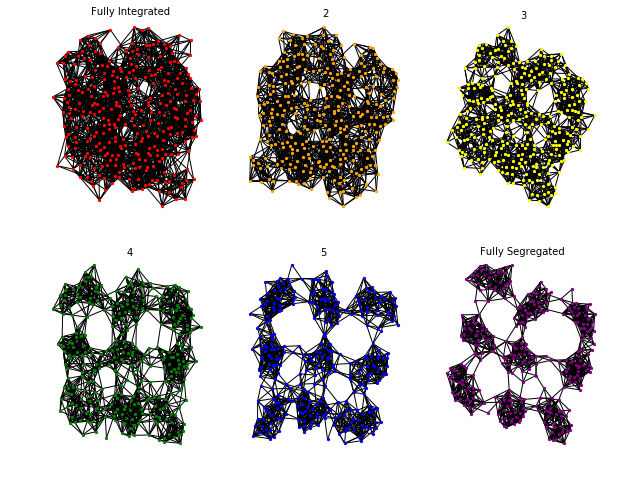

In [19]:
#EXAMPLE NWS


fig,axes=plt.subplots(2,3,figsize=(10,8))
network=0
i = 0
for ax in axes.flat:
    pos=nx.kamada_kawai_layout(NWN[i][network]['G'])
    nx.draw(NWN[i][network]['G'],pos=pos,ax=ax,node_size=5,node_color=colors[i])
    if i == 0 or i == 5:
        ax.text(-0.5,1.1,names[i])
    else:
        ax.text(0,1.1,names[i])
    
    i=i+1

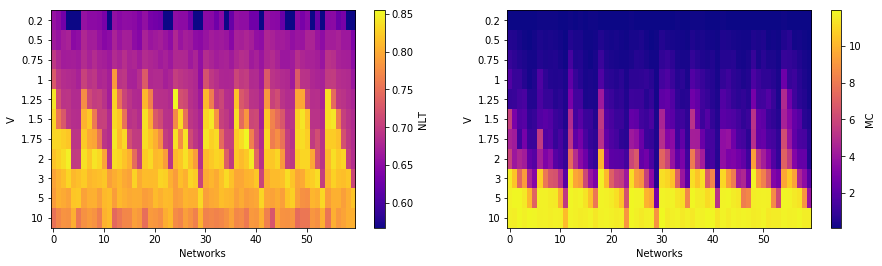

In [31]:
#Voltage vs NLT:
fig,axes=plt.subplots(1,2,figsize=(15,4))
fig.subplots_adjust(wspace=0.2)
ax=axes[0]
a=ax.imshow(results,aspect='auto',cmap=plt.cm.plasma)
ax.set_xlabel('Networks')
ax.set_ylabel('V')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)
plt.colorbar(a,ax=ax,label='NLT')

ax=axes[1]
#Voltage vs MC:
b=ax.imshow(resultsMC,aspect='auto',cmap=plt.cm.plasma)
ax.set_xlabel('Networks')
ax.set_ylabel('V')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)
plt.colorbar(b,ax=ax,label='MC')

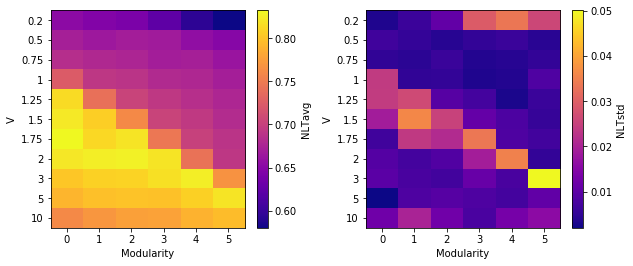

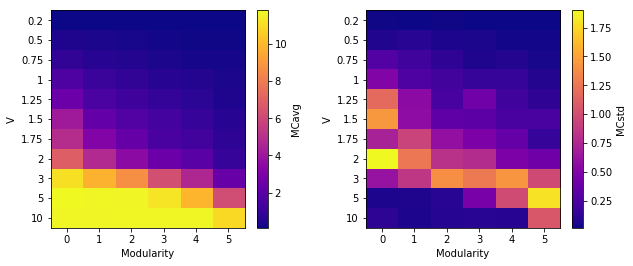

In [22]:
#Voltage vs Density (avg across 10 networks for each combination):
fig,axes=plt.subplots(1,2,figsize=(10,4))
fig.subplots_adjust(wspace=0.3)
ax=axes[0]
a=ax.imshow(np.mean(newResults,axis=2),aspect='auto',cmap=plt.cm.plasma)
ax.set_xlabel('Modularity')
ax.set_ylabel('V')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)

plt.colorbar(a,ax=ax,label='NLTavg')

ax=axes[1]
#Voltage vs Density (std across 10 networks for each combination):
b=ax.imshow(np.std(newResults,axis=2),aspect='auto',cmap=plt.cm.plasma)
ax.set_xlabel('Modularity')
ax.set_ylabel('V')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)

plt.colorbar(b,ax=ax,label='NLTstd')

#Voltage vs Density (avg across 10 networks for each combination):
fig,axes=plt.subplots(1,2,figsize=(10,4))
fig.subplots_adjust(wspace=0.3)
ax=axes[0]
a=ax.imshow(np.mean(newResultsMC,axis=2),aspect='auto',cmap=plt.cm.plasma)
ax.set_xlabel('Modularity')
ax.set_ylabel('V')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)

plt.colorbar(a,ax=ax,label='MCavg')

ax=axes[1]
#Voltage vs Density (std across 10 networks for each combination):
b=ax.imshow(np.std(newResultsMC,axis=2),aspect='auto',cmap=plt.cm.plasma)
ax.set_xlabel('Modularity')
ax.set_ylabel('V')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)

plt.colorbar(b,ax=ax,label='MCstd')

In [321]:
np.mean(newResults,axis=2)

array([[0.65365542, 0.64692819, 0.64212383, 0.62266351, 0.59407014,
        0.57993849],
       [0.67175634, 0.66577205, 0.67060237, 0.6684215 , 0.65686554,
        0.6500142 ],
       [0.68517374, 0.68018755, 0.67707424, 0.67000826, 0.67244991,
        0.66261132],
       [0.72494856, 0.69300227, 0.69024866, 0.68133044, 0.67898814,
        0.67100401],
       [0.81580678, 0.74088053, 0.70422182, 0.69374402, 0.68603492,
        0.67774408],
       [0.82356295, 0.80733833, 0.76122087, 0.70383352, 0.69481328,
        0.68295914],
       [0.83262936, 0.81297913, 0.82025764, 0.74698608, 0.70212231,
        0.68978892],
       [0.82213242, 0.82578688, 0.82830886, 0.82040619, 0.74289214,
        0.69339091],
       [0.8023115 , 0.80978074, 0.81033399, 0.81838619, 0.82622371,
        0.76775503],
       [0.79127522, 0.79837713, 0.8004713 , 0.79920242, 0.80838203,
        0.82022851],
       [0.76077029, 0.77066128, 0.77740537, 0.77914357, 0.78958955,
        0.79645744]])

Text(0, 0.5, 'NLT')

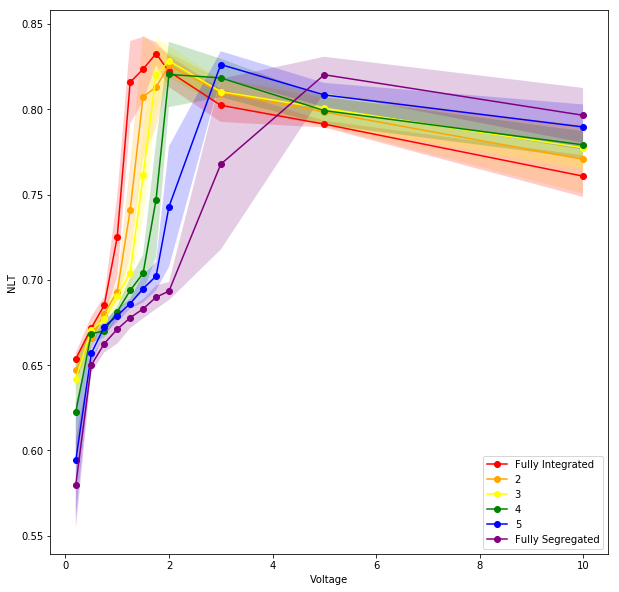

In [307]:
plt.figure(figsize=(10,10))

x=onAmp
y=np.mean(newResults,axis=2).T
err=np.std(newResults,axis=2).T
for i in range(len(y)):
    h=plt.plot(x,y[i],'-o',c=colors[i])
    plt.fill_between(x,y[i]-err[i],y[i]+err[i],alpha=0.2,facecolor=colors[i])

plt.legend(names)
plt.xlabel('Voltage')
plt.ylabel('NLT')

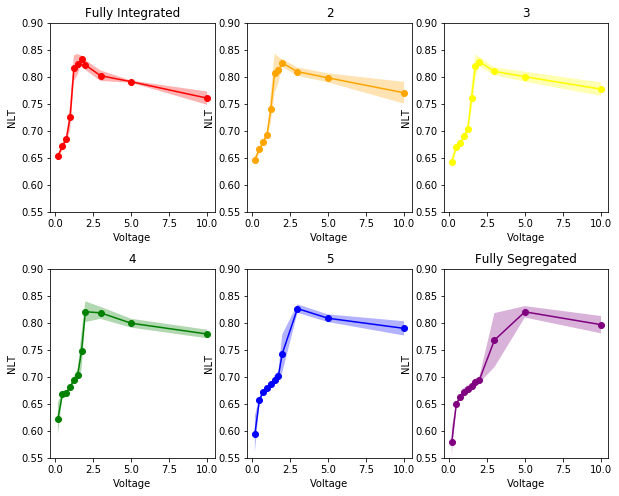

In [21]:
fig,axes=plt.subplots(2,3,figsize=(10,8))
fig.subplots_adjust(hspace=0.3)
x=onAmp
y=np.mean(newResults,axis=2).T
err=np.std(newResults,axis=2).T
i = 0
a=[]
for ax in axes.flat:
    a.append(ax.plot(x,y[i],'-o',c=colors[i]))
    ax.fill_between(x,y[i]-err[i],y[i]+err[i],alpha=0.3,facecolor=colors[i])
    ax.set_ylim([0.55,0.9])
    ax.set_title(names[i])
    i=i+1
    ax.set_ylabel('NLT')
    ax.set_xlabel('Voltage')
# plt.legend([a[0][0],a[1][0],a[2][0],a[3][0],a[4][0],a[5][0]],names)

In [41]:
asn_acc_new=(newResults-np.min(newResults))/(np.max(newResults)-np.min(newResults))
asn_mc_new=(newResultsMC-np.min(newResultsMC))/(np.max(newResultsMC)-np.min(newResultsMC))

In [42]:
voltAxis=0
modAxis=1

(0, 12)

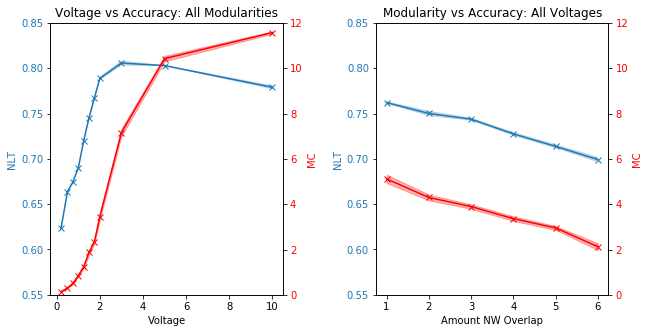

In [43]:
#Voltage vs Accuracy, all densities:
fig,axes=plt.subplots(1,2,figsize=(10,5))
fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)
ax=axes[0]
ax.set_title('Voltage vs Accuracy: All Modularities')

avgNLT=np.mean(newResults,axis=1)
stdNLT=np.std(newResults,axis=1)

avgMC=np.mean(newResultsMC,axis=1)
stdMC=np.std(newResultsMC,axis=1)

y=np.mean(avgNLT,axis=1)
x=onAmp
err=np.std(avgNLT,axis=1)/np.sqrt(len(avgNLT))
y2=np.mean(avgMC,axis=1)
err2=np.std(avgMC,axis=1)/np.sqrt(len(avgMC))

ax.plot(x,y,'-x')
ax.fill_between(x,y-err,y+err,alpha=0.3)
ax.set_ylim([0.55,0.85])
ax.set_ylabel('NLT',color='tab:blue')
ax.set_xlabel('Voltage')

ax.tick_params(axis='y',labelcolor='tab:blue')
ax2=ax.twinx()
ax2.plot(x,y2,'-x',c='r')
ax2.fill_between(x,y2-err2,y2+err2,alpha=0.3,color='r')

ax2.set_ylim([0,12])
ax2.tick_params(axis='y',labelcolor='red')
ax2.set_ylabel('MC',color='r')

#Density vs Accuracy, all voltages:
ax1=axes[1]
ax1.set_title('Modularity vs Accuracy: All Voltages')
avgNLT=np.mean(newResults,axis=0)
stdNLT=np.std(newResults,axis=0)

avgMC=np.mean(newResultsMC,axis=0)
stdMC=np.std(newResultsMC,axis=0)


y=np.mean(avgNLT,axis=1)
x=distanceFromCenter[0]
err=np.std(avgNLT,axis=1)/np.sqrt(len(avgNLT))
y2=np.mean(avgMC,axis=1)
err2=np.std(avgMC,axis=1)/np.sqrt(len(avgMC))


ax1.plot(x,y,'-x')
ax1.fill_between(x,y-err,y+err,alpha=0.3,)
ax1.set_ylabel('NLT',color='tab:blue')
ax1.tick_params(axis='y',labelcolor='tab:blue')
ax1.set_ylim([0.55,0.85])
ax1.set_xlabel('Amount NW Overlap')
ax2=ax1.twinx()
ax2.set_ylabel('MC',color='r')
ax2.plot(x,y2,'-x',c='r')
ax2.fill_between(x,y2-err2,y2+err2,alpha=0.3,color='r')
ax2.tick_params(axis='y',labelcolor='red')
ax2.set_ylim([0,12])

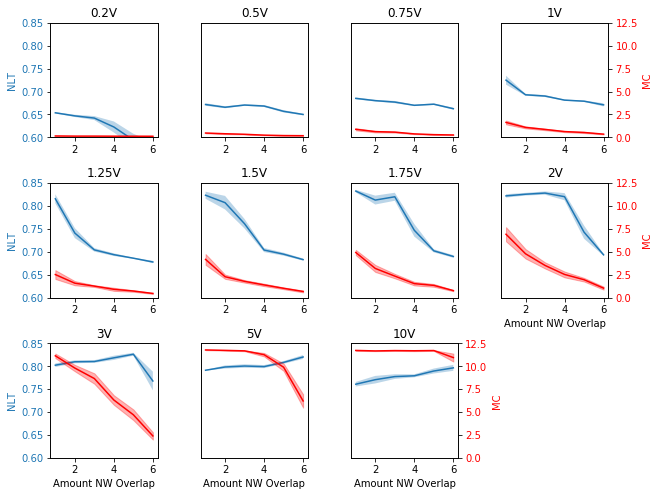

In [54]:
#Voltage vs Dinstance from Center vs Accuracy:

fig,axes=plt.subplots(3,4,figsize=(10,8))
fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)
i=0
xx=[]
for ax in axes.flat:#for each voltage:
    #plot accuracy vs density:
    if i < 11:
        ax.set_title(str(onAmp[i])+'V')
#         ax.set_xlim([0,300])
        ax.set_ylim(0.6,0.85)
        if i == 0 or i == 4 or i == 8:
            ax.set_ylabel('NLT',color='tab:blue')
            ax.tick_params(axis='y',labelcolor='tab:blue')
        else:
            ax.set_yticks([])
        y=np.mean(newResults[i],axis=1)
        err=np.std(newResults[i],axis=1)/np.sqrt(len(newResults[i]))
        x=distanceFromCenter[0]
        ax.plot(x,y)

        ax.fill_between(distanceFromCenter[0],y-err,y+err,alpha=0.3)
        if i==7 or i == 8 or i ==9 or i ==10:
            ax.set_xlabel('Amount NW Overlap')
        ax2=ax.twinx()
        ax2.set_ylim(0,12.5)
        if i == 3 or i == 7 or i == 10:
            ax2.set_ylabel('MC',color='r')
            ax2.tick_params(axis='y',labelcolor='red')

        else:
            ax2.set_yticks([])
        y2=np.mean(newResultsMC[i],axis=1)
        err2=np.std(newResultsMC[i],axis=1)/np.sqrt(len(newResultsMC[i]))
        ax2.plot(x,y2,'r')
        ax2.fill_between(x,y2-err2,y2+err2,color='r',alpha=0.3)
        
        #max accuracy standardized NLT + MC
        yy=np.mean(asn_acc_new[i],axis=1)
        yy2=np.mean(asn_mc_new[i],axis=1)
        xx.append(x[np.argmax(yy2+yy)])
#         ax2.vlines(xx[i],linestyles='dashed',ymin=0,ymax=12.5)

    else:
        ax.set_frame_on(False)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
    i = i+1
    
# plt.savefig(saveLoc+'AvgDeg vs NLT & MC - VSweep 300NWN Varying Density.png',format='png',dpi=300)

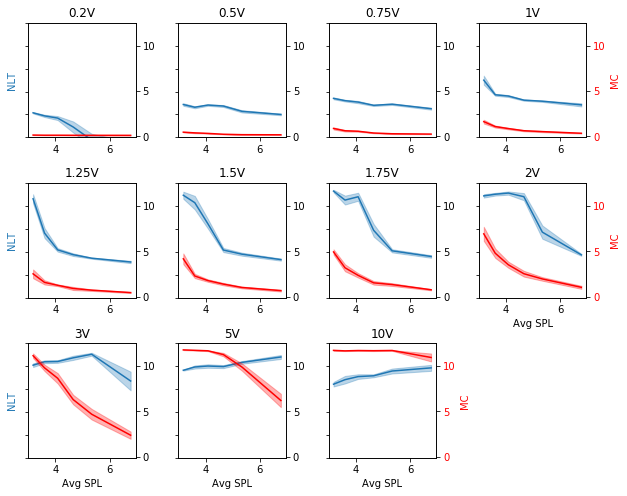

In [80]:
#Voltage vs Avg SPL (source to drain) vs Accuracy:
    
spl=np.array(spl).reshape(6,10)

fig,axes=plt.subplots(3,4,figsize=(10,8))
fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)
i=0
xx=[]
for ax in axes.flat:#for each voltage:
    #plot accuracy vs density:
    if i < 11:
        ax.set_title(str(onAmp[i])+'V')
#         ax.set_xlim([0,300])
        ax.set_ylim(0.6,0.85)
        if i == 0 or i == 4 or i == 8:
            ax.set_ylabel('NLT',color='tab:blue')
            ax.tick_params(axis='y',labelcolor='tab:blue')
        else:
            ax.set_yticklabels([])
        y=np.mean(newResults[i],axis=modAxis)
        err=np.std(newResults[i],axis=modAxis)/np.sqrt(len(newResults[i]))
        x=np.mean(spl,axis=1)
        ax.plot(x,y,c='tab:blue')

        ax.fill_between(x,y-err,y+err,alpha=0.3,color='tab:blue')
        if i==7 or i == 8 or i ==9 or i ==10:
            ax.set_xlabel('Avg SPL')
        ax2=ax.twinx()
        ax2.set_ylim(-0.1,12.5)
        if i == 3 or i == 7 or i == 10:
            ax2.set_ylabel('MC',color='r')
            ax2.tick_params(axis='y',labelcolor='red')

        else:
            ax.set_yticklabels([])
        y2=np.mean(newResultsMC[i],axis=modAxis)
        err2=np.std(newResultsMC[i],axis=modAxis)/np.sqrt(len(newResultsMC[i]))
        ax2.plot(x,y2,'r')
        ax2.fill_between(x,y2-err2,y2+err2,color='r',alpha=0.3)
        
        #max accuracy standardized NLT + MC
        yy=np.mean(asn_acc_new[i],axis=modAxis)
        yy2=np.mean(asn_mc_new[i],axis=modAxis)
        xx.append(x[np.argmax(yy2+yy)])
#         ax2.vlines(xx[i],linestyles='dashed',ymin=0,ymax=12.5)

    else:
        ax.set_frame_on(False)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
    i = i+1

# plt.savefig(saveLoc+'SPL vs NLT & MC - VSweep 300NWN Varying Density.png',format='png',dpi=300)

#### Network Level Analysis

In [44]:
import matplotlib.colors as clrs


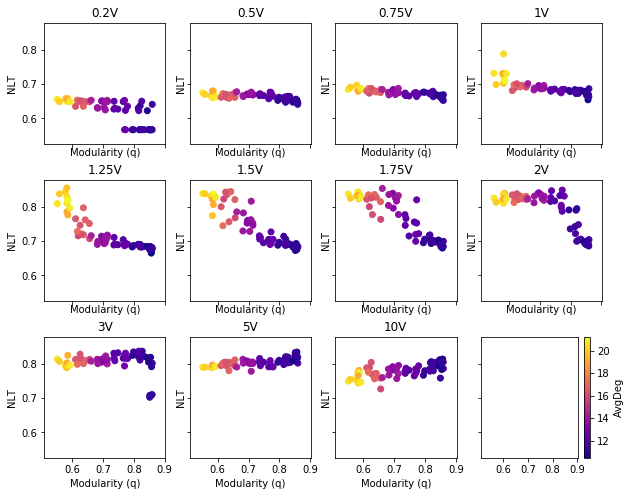

In [48]:
fig,axes=plt.subplots(3,4,figsize=(10,8),sharex=True,sharey=True)
fig.subplots_adjust(hspace=0.3)

i=0
for ax in axes.flat:
    if i<11:
        ax.set_title(str(onAmp[i])+'V')
        a=ax.scatter(mod,newResults[i],cmap=plt.cm.plasma,c=avgDeg)
        ax.set_xlabel('Modularity (q)')
        ax.set_ylabel('NLT')
    else:
        plt.colorbar(a,ax=ax,label='AvgDeg')
    i=i+1
    
plt.savefig(saveLoc+'VSweep 300NWN Varying Modularity - Unweighted Graph Modularity vs NLT.png',format='png',dpi=300)

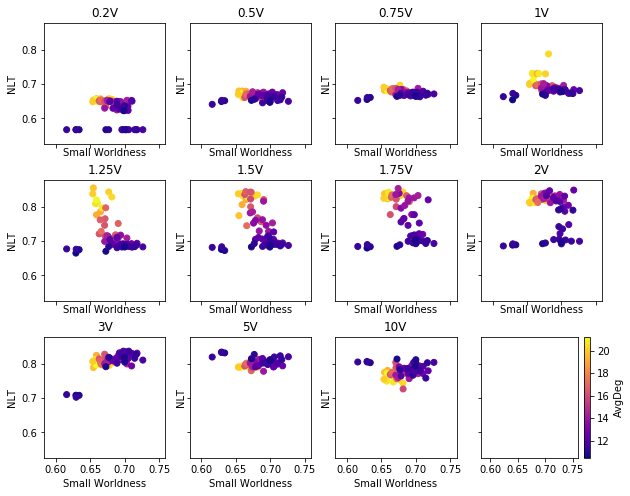

In [50]:
fig,axes=plt.subplots(3,4,figsize=(10,8),sharex=True,sharey=True)
fig.subplots_adjust(hspace=0.3)

i=0
for ax in axes.flat:
    if i<11:
        ax.set_title(str(onAmp[i])+'V')
        a=ax.scatter(smallworld,newResults[i],cmap=plt.cm.plasma,c=avgDeg)
        ax.set_xlabel('Small Worldness')
        ax.set_ylabel('NLT')
    else:
        plt.colorbar(a,ax=ax,label='AvgDeg')
    i=i+1
    
plt.savefig(saveLoc+'VSweep 300NWN Varying Modularity - Unweighted Graph SW vs NLT.png',format='png',dpi=300)

#### Node Level Analysis

In [175]:
# PCAll=np.array(np.tile(pcoeff,(1,11)))
# MZAll=np.tile(mz,(1,11))

# # # degCent=np.array(degCent).reshape(6,10)

# # tempPCAll=PCAll.reshape(11,10,6)
# # tempMZAll=MZAll.reshape((11,10,6))
# # MZAll=[];PCAll=[]
# # for i in range(len(tempPCAll)):
# #     PCAll.append(tempPCAll[i].T)
# #     MZAll.append(tempMZAll[i].T)

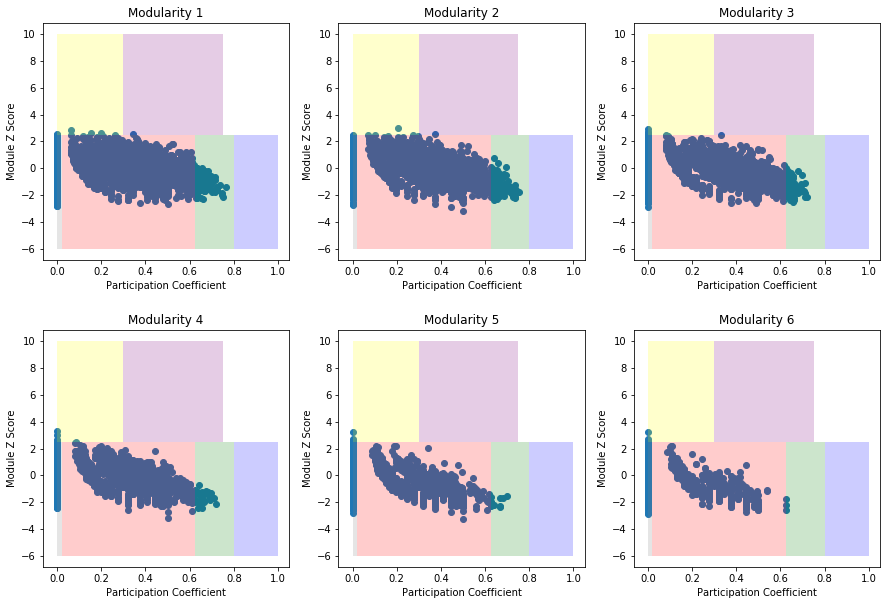

In [94]:
#ALL NETWORKS PCOEFF VS MZ
fig,axes=plt.subplots(2,3,figsize=(15,10))
fig.subplots_adjust(hspace=.3)

i=0
for ax in axes.flat:    
    draw_zp_space(ax=ax)
    ax.set_title('Modularity ' + str(distanceFromCenter[0][i]))
    ax.scatter(np.hstack(pcoeff[i]),np.hstack(mz[i]))
    i=i+1
    
plt.savefig(saveLoc+'Modularity PC vs MZ - VSweep 300NWN Varying Modularity.png',format='png',dpi=300)

In [51]:
#Set indexes of best and worst networks for each voltage and density
numNWs=1
maxNLT=[[] for i in range(len(newResults))];maxMC=[[] for i in range(len(newResults))]
minNLT=[[] for i in range(len(newResults))];minMC=[[] for i in range(len(newResults))]

idxMaxNLT=[[] for i in range(len(newResults))];idxMaxMC=[[] for i in range(len(newResults))]
idxMinNLT=[[] for i in range(len(newResults))];idxMinMC=[[] for i in range(len(newResults))]

for i in range(len(newResults)):
    for j in range(len(newResults[i])):
        maxNLT[i].append(np.sort(newResults[i][j])[-numNWs:])
        maxMC[i].append(np.sort(newResultsMC[i][j])[-numNWs:])
        idxMaxNLT[i].append(np.argsort(newResults[i][j])[-numNWs:])
        idxMaxMC[i].append(np.argsort(newResultsMC[i][j])[-numNWs:])
        
        minNLT[i].append(np.sort(newResults[i][j])[:numNWs])
        minMC[i].append(np.sort(newResultsMC[i][j])[:numNWs])
        idxMinNLT[i].append(np.argsort(newResults[i][j])[:numNWs])
        idxMinMC[i].append(np.argsort(newResultsMC[i][j])[:numNWs])

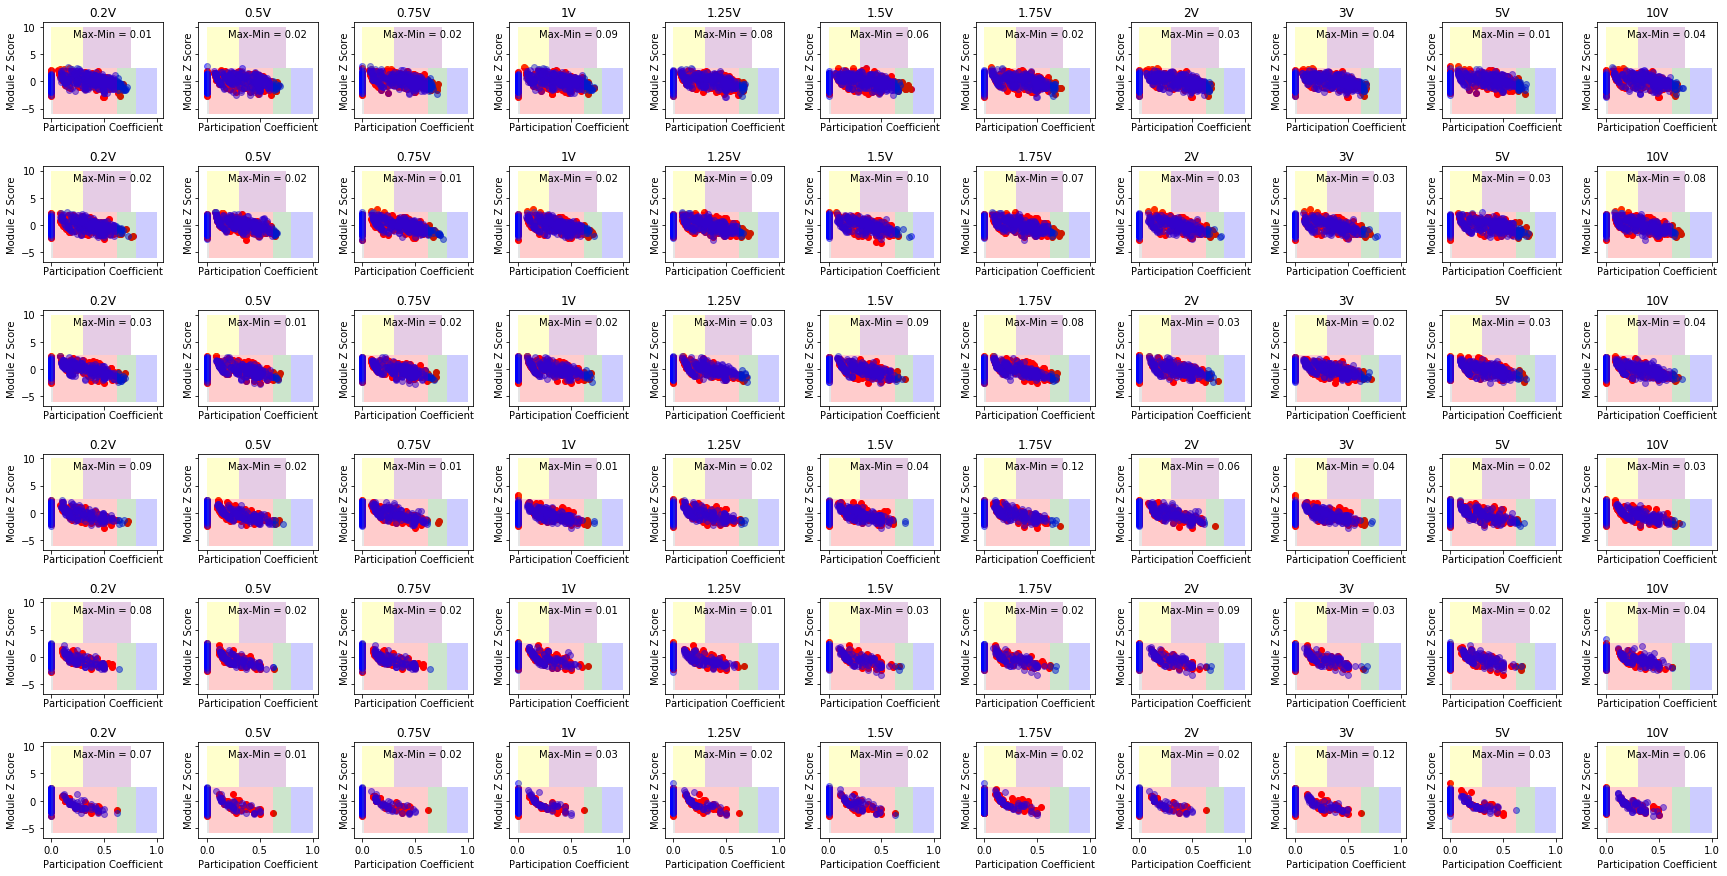

In [73]:
#Plot PCOEFF for each density - NLT
volt=7
fig,axes=plt.subplots(6,11,figsize=(30,15),sharex=True,sharey=True)
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.3)

for i in range(len(newResults)):
    for j in range(len(newResults[i])):
        ax=axes[j][i]
        ax.set_title(str(onAmp[i]) +'V')
        draw_zp_space(ax=ax)
        idx=idxMaxNLT[i][j]
    #     ax.set_title('Avg Deg ' + str(np.around(np.mean(avgDeg[i],axis=0),decimals=2)))
        pcMaxNLT=np.hstack([pcoeff[j][k] for k in idx])
        mzMaxNLT=np.hstack([mz[j][k] for k in idx])
        ax.text(0.2,8,'Max-Min = '+"{0:.2f}".format(np.max(maxNLT[i][j])-np.min(minNLT[i][j])))
        ax.scatter(pcMaxNLT,mzMaxNLT,c='r')
        idx2=idxMinNLT[i][j]
        pcMinNLT=np.hstack([pcoeff[j][k] for k in idx2])
        mzMinNLT=np.hstack([mz[j][k] for k in idx2])
        ax.scatter(pcMinNLT,mzMinNLT,c='b',alpha=0.5)
    
# #PCOEFF for each density - MC
# fig,axes=plt.subplots(2,3,figsize=(15,10))
# fig.subplots_adjust(hspace=.5)
# fig.subplots_adjust(wspace=.3)
# i=0
# fig.suptitle('Voltage = ' + str(onAmp[volt]) +'V, Task = MC',y=0.93)
# for ax in axes.flat:
#     draw_zp_space(ax=ax)
#     idx=idxMaxMC[volt][i]
# #     ax.set_title('Avg Deg ' + str(np.around(np.mean(avgDeg[i],axis=0),decimals=2)))
#     pcMaxMC=np.hstack([pcoeff[i][j] for j in idx])
#     mzMaxMC=np.hstack([mz[i][j] for j in idx])
#     ax.text(0.3,8,'Max-Min = '+"{0:.2f}".format(np.max(maxMC[volt][i])-np.min(minMC[volt][i])))
#     ax.scatter(pcMaxMC,mzMaxMC,c='r')
#     idx2=idxMinMC[volt][i]
#     pcMinMC=np.hstack([pcoeff[i][j] for j in idx2])
#     mzMinMC=np.hstack([mz[i][j] for j in idx2])
#     ax.scatter(pcMinMC,mzMinMC,c='b',alpha=0.5)
#     i=i+1
    


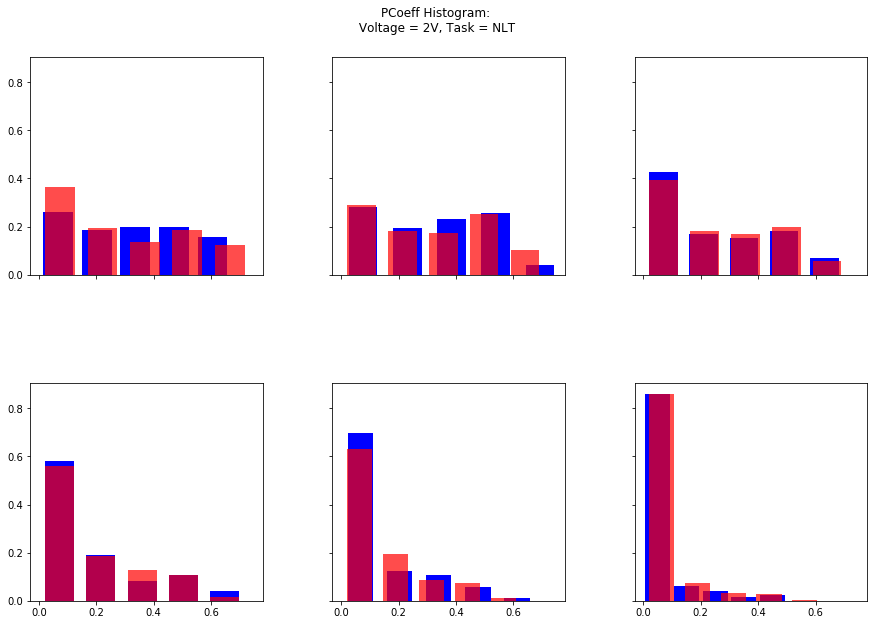

In [197]:
#Plot PCoeff Histograms
volt=7
fig,axes=plt.subplots(2,3,figsize=(15,10),sharex=True,sharey=True)
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.3)
i=0
fig.suptitle('PCoeff Histogram:\n Voltage = ' + str(onAmp[volt]) +'V, Task = NLT',y=0.95)
for ax in axes.flat:
#     ax.set_title('Avg Deg ' + str(np.around(np.mean(avgDeg[i],axis=0),decimals=2)))
    idx=idxMaxNLT[volt][i]
    idx2=idxMinNLT[volt][i]
    pcMaxNLT=np.hstack([pcoeff[i][j] for j in idx])
    pcMinNLT=np.hstack([pcoeff[i][j] for j in idx2])
    hist, bins=np.histogram(pcMaxNLT,5)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    histMin, binsMin=np.histogram(pcMinNLT,5)
    widthMin=0.7 * (binsMin[1] - binsMin[0])
    centerMin=(binsMin[:-1] + binsMin[1:]) / 2
    ax.bar(centerMin, histMin/len(pcMinNLT), align='center', width=width,label='Min',color='b')
    ax.bar(center, hist/len(pcMaxNLT), align='center', width=width,label='Max',color='r',alpha=0.7)
#     ax.set_xlim([0,1])
    if i >=15:
        ax.set_xlabel('PC')
    i=i+1

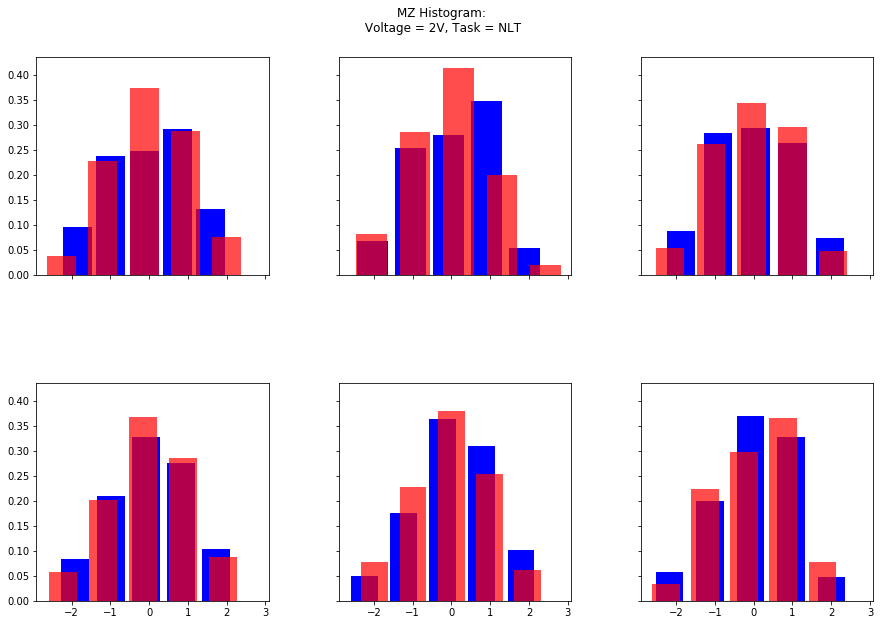

In [199]:
#Plot PCoeff Histograms
volt=7
fig,axes=plt.subplots(2,3,figsize=(15,10),sharex=True,sharey=True)
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.3)
i=0
fig.suptitle('MZ Histogram:\n Voltage = ' + str(onAmp[volt]) +'V, Task = NLT',y=0.95)
for ax in axes.flat:
#     ax.set_title('Avg Deg ' + str(np.around(np.mean(avgDeg[i],axis=0),decimals=2)))
    idx=idxMaxNLT[volt][i]
    idx2=idxMinNLT[volt][i]
    mzMaxNLT=np.hstack([mz[i][j] for j in idx])
    mzMinNLT=np.hstack([mz[i][j] for j in idx2])
    hist, bins=np.histogram(mzMaxNLT,5)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    histMin, binsMin=np.histogram(mzMinNLT,5)
    widthMin=0.7 * (binsMin[1] - binsMin[0])
    centerMin=(binsMin[:-1] + binsMin[1:]) / 2
    ax.bar(centerMin, histMin/len(mzMinNLT), align='center', width=width,label='Min',color='b')
    ax.bar(center, hist/len(mzMaxNLT), align='center', width=width,label='Max',color='r',alpha=0.7)
#     ax.set_xlim([0,1])
    if i >=15:
        ax.set_xlabel('MZ')
    i=i+1

Text(0.5, 0, 'NLT')

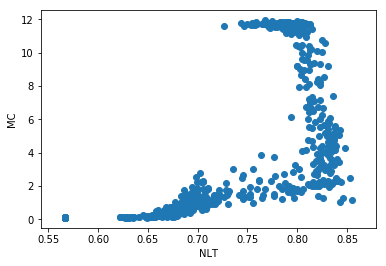

In [85]:
#Delta
plt.scatter(newResults,newResultsMC)
plt.ylabel('MC')
plt.xlabel('NLT')


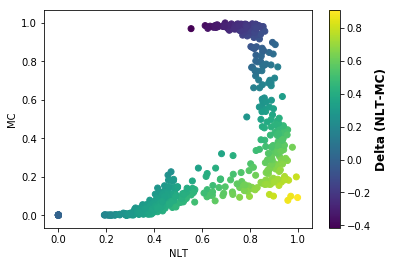

In [95]:
#Standardized Scatter MC vs NLT:
# logAsn_mc=np.log(asn_mc)
# plt.scatter(asn_acc,logAsn_mc) #original scatter
plt.figure()
delta=asn_acc_new-asn_mc_new #delta tells us how much better each network is at NLT compared to MC
plt.scatter(asn_acc_new,asn_mc_new,c=delta)
plt.xlabel('NLT')
plt.ylabel('MC')
cb=plt.colorbar()
cb.set_label(label='Delta (NLT-MC)', size='large', weight='bold')
# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/BA Standardized VSweep Delta (NLT-MC)',dpi=300)    

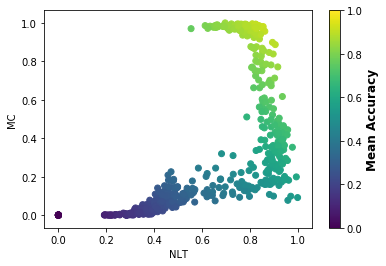

In [96]:
#Standardized Scatter MC vs NLT:
# logAsn_mc=np.log(asn_mc)
# plt.scatter(asn_acc,logAsn_mc) #original scatter
mean_accuracy=np.mean([asn_acc_new,asn_mc_new],0)

plt.figure()
plt.scatter(asn_acc_new,asn_mc_new,c=mean_accuracy,vmin=0,vmax=1)
plt.xlabel('NLT')
plt.ylabel('MC')
cb=plt.colorbar()
cb.set_label(label='Mean Accuracy', size='large', weight='bold')
# plt.savefig('/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/BA Standardized VSweep vs Mean Accuracy',dpi=300)    

In [76]:
a='/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks'

In [77]:
# #save mean accuracy + delta:
# # data={'Delta':delta,'MeanAcc':mean_accuracy,'PC':pcoeff,'MZ':mz}
# for i in range(len(onAmp)):
#     data={'Delta':delta[i],'MeanAcc':mean_accuracy[i],'PC':PCAll[i],'MZ':MZAll[i]}
#     savemat(a+'/Delta Mean Acc/Delta_MeanAcc_NWN_9modules_'+str(voltNames[i])+'V.mat',data)

#### Other Network Comparison Methods

In [62]:
maxGraph=[[] for i in range(len(newResults))]
minGraph=[[] for i in range(len(newResults))]
for volt in tqdm(range(len(newResults))): #for each voltage
    for i in range(len(idxMaxNLT[volt])): #for each density
        maxGraph[volt].append(nx.from_numpy_array(NWN[i][idxMaxNLT[volt][i][0]]['adj_matrix']))
        minGraph[volt].append(nx.from_numpy_array(NWN[i][idxMinNLT[volt][i][0]]['adj_matrix']))

In [64]:
#Find Normalized Laplacian Spectrum of each with similar density
LspecNWNMax=[[] for i in range(len(newResults))]
LspecNWNMin=[[] for i in range(len(newResults))]
b=[]
c=[]
for i in tqdm(range(len(newResults))): #for each voltage
    for j in range(len(NWN)): #for each density
        b=normalized_laplacian_spectrum(maxGraph[i][j])
        LspecNWNMax[i].append(b)
        c=normalized_laplacian_spectrum(minGraph[i][j])
        LspecNWNMin[i].append(c)

In [65]:
sigma = 0.015
dx = 0.001
sig2 = 2*np.pi*sigma**2
x = np.arange(0, 2, dx)
gammaMax=[[] for i in range(len(LspecNWNMax))];gammaMaxSTD=[[] for i in range(len(LspecNWNMax))]
gammaMin=[[] for i in range(len(LspecNWNMin))];gammaMinSTD=[[] for i in range(len(LspecNWNMin))]

for i in tqdm(range(len(LspecNWNMax))):
    temp=[];temp2=[]
    for j in range(len(LspecNWNMax[i])):
        a=np.array([np.sum(np.exp(-(abs(x[m]-LspecNWNMax[i][j])**2)/(sig2/np.pi)))/np.sqrt(sig2) for m in range(len(x))])
        a=a/np.sum(a)/dx
        temp.append(a)
        b=np.array([np.sum(np.exp(-(abs(x[m]-LspecNWNMin[i][j])**2)/(sig2/np.pi)))/np.sqrt(sig2) for m in range(len(x))])
        b=b/np.sum(b)/dx
        temp2.append(b)
    gammaMax[i].append(temp)
#         gammaMaxSTD[i].append(temp)
    gammaMin[i].append(temp2)
#         gammaMinSTD[i].append(np.nanstd(temp2,axis=0))

In [55]:
#Delta Con
temp=[]
a=loadmat(r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/ModularNWNs/deltacon_NLT_300NW_9modules_NWN_allVolts.mat')
temp=a['deltacon'][0]

In [56]:
def empty(value):
    try:
        value = float(value)
    except ValueError:
        pass
    except TypeError:
        value=0
    return bool(value)

In [58]:
deltacon=[]
count=0
for i in range(len(temp)):
    for j in range(len(temp[i][0])):
        if empty(np.double(temp[i][0][j]).tolist()):
            deltacon.append(np.double(temp[i][0][j]))
        else:
            deltacon.append(np.nan)
        count=count+1
deltacon=np.array(deltacon).reshape(11,6)

In [59]:
deltacon=pd.DataFrame(deltacon)

In [60]:
deltacon

0         1         2         3         4         5
0   0.570404  0.638220  0.614641  0.601927  0.628698  0.532050
1   0.588161  0.674212  0.622153  0.559304  0.636064  0.438898
2   0.610574  0.640385  0.600650  0.477749  0.639847  0.320631
3   0.618697  0.580054  0.625399  0.448787  0.632263  0.247391
4   0.628670  0.508587  0.638571  0.323440  0.640903  0.201637
5   0.626795  0.432049  0.647085  0.249245  0.661715  0.566912
6   0.616003  0.324331  0.646303  0.204497  0.647937  0.588025
7   0.639967  0.256763  0.641430  0.599838  0.636137  0.608542
8   0.649252  0.208511  0.657274  0.607459  0.617428  0.619887
9   0.643846  0.598057  0.663435  0.582475  0.589152  0.628305
10  0.646760  0.612606  0.647684  0.608321  0.596892  0.633132

In [77]:
#Graphlet Distance:
GCD11=[]
#Graphlet Distance:
GCD11=[]
folder= r"/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/Leda Graphs/Modular/"
[GCD11,corrMats]=decompress_pickle(folder+'300NW_9Modules_UnweightedNWs_GCD.pkl')

In [78]:
GCD11=np.array(GCD11).reshape(660,660)

In [81]:
#Network Comparison Methods:
import netlsd as nd
maxmin=[];specDist=[];netsimile=[];netlsd=[];portDiv=[];
GCD11maxmin=[]
for i in tqdm(range(len(newResults))):
    temp=[];tempMaxMin=[];temp2=[];temp3=[]
    for j in range(len(NWN)):
        idx=idxMaxNLT[i][j][0]
        idxMin=idxMinNLT[i][j][0]
        GCD11maxmin.append(GCD11[(i+1)*(j+1)*(idx+1)-1,(i+1)*(j+1)*(idxMin+1)-1])
        count=count+1
        A=NWN[j][idx]['adj_matrix']
        B=NWN[j][idxMin]['adj_matrix']
        gMax=nx.from_numpy_array(A)
        gMin=nx.from_numpy_array(B)
        desc1=nd.heat(gMax) # compute the signature)
        desc2=nd.heat(gMin)
        netlsd.append(nd.compare(desc1, desc2))
        if len(gMax) > 3 and len(gMin) > 3:
            temp.append(portrait_divergence(gMax,gMin))
        else:
            temp.append(0)            
        tempMaxMin.append(maxNLT[i][j][0]-minNLT[i][j][0])
        temp3.append(np.linalg.norm(gammaMax[i][0][j]-gammaMin[i][0][j]))
#     delcon.append(temp)
    maxmin.append(tempMaxMin)
    portDiv.append(temp)
    specDist.append(temp3)
#     netsimile.append(temp2)
portDiv=np.array(portDiv).reshape(11,6)
specDist=np.array(specDist).reshape(11,6)
netlsd=np.array(netlsd).reshape(11,6)
GCD11maxmin=np.array(GCD11maxmin).reshape(11,6)

ValueError: cannot reshape array of size 66 into shape (11,20)

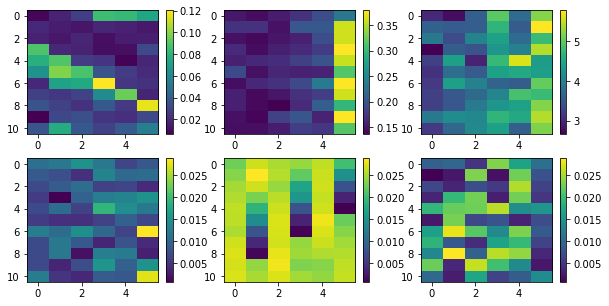

In [83]:
fig,axes=plt.subplots(2,3,figsize=(10,5))

a=axes[0][0].imshow(maxmin,aspect='auto')
plt.colorbar(a,ax=axes[0][0])
b=axes[0][1].imshow(portDiv,aspect='auto')
plt.colorbar(b,ax=axes[0][1])
c=axes[0][2].imshow(specDist,aspect='auto')
plt.colorbar(c,ax=axes[0][2])
d=axes[1][0].imshow(netlsd,aspect='auto')
plt.colorbar(d,ax=axes[1][0])
e=axes[1][1].imshow(deltacon,aspect='auto')
plt.colorbar(d,ax=axes[1][1])
f=axes[1][2].imshow(GCD11maxmin,aspect='auto')
plt.colorbar(d,ax=axes[1][2])

---

### Thresholded Subgraph Analysis

In [84]:
folder='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/NWN Results/'

In [24]:
# #LOAD ONLY VOLTAGES in volts
# NWN_NLT_sims=[[] for i in range(len(volts))]
# NWN_MC_sims=[[] for i in range(len(volts))]
# voltNames=['0p2','0p5','0p75','1','1p25','1p5','1p75','2','3','5','10']
# j=0
# for volt in volts:
#     for i in range(len(networks)):
#         name=folder+'NWN_NLT_Simulation_Network_9modules_'+str(i+1)+'_'+voltNames[volt]+'v.pkl'
#         name2=folder+'NWNMC_Simulation_Network_9modules_'+str(i+1)+'_'+voltNames[volt]+'v.pkl'
#         NWN_NLT_sims[j].append(decompress_pickle(name))
#         NWN_MC_sims[j].append(decompress_pickle(name2))
#     j=j+1

In [85]:
#LOAD ALL VOLTAGES
NWN_NLT_sims=[[] for i in range(len(voltNames))]
NWN_MC_sims=[[] for i in range(len(voltNames))]
j = 0
for i in tqdm(range(len(voltNames))):
    for k in range(len(networksFlipped)):
        name=folder+'NWN_NLT_Simulation_Network_9modules_'+str(k+1)+'_'+voltNames[i]+'v.pkl'
        name2=folder+'NWNMC_Simulation_Network_9modules_'+str(k+1)+'_'+voltNames[i]+'v.pkl'
        NWN_NLT_sims[j].append(decompress_pickle(name))
        NWN_MC_sims[j].append(decompress_pickle(name2))        
    j=j+1

In [91]:
#Subgraph AdjMat

#Threshold by conductance - when tunnelling becomes appreciable (offResistance * 10)

def getOnGraph(sims,network):#, this_TimeStamp = 0):
    edgeList = network['edge_list']
    adjMat = np.zeros((network['number_of_wires'], network['number_of_wires']))
#     set_trace()
    adjMat[edgeList[:,0], edgeList[:,1]] = (1/sims['JunctionResistance'])>1e-06#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    adjMat[edgeList[:,1], edgeList[:,0]] = (1/sims['JunctionResistance'])>1e-06#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    onGraph = nx.from_numpy_array(adjMat)
    onGraph=nx.DiGraph.to_undirected(onGraph)
    
    return onGraph

def getWeightedGraph(sims,network):#, this_TimeStamp = 0):
    edgeList = network['edge_list']
    adjMat = np.zeros((network['number_of_wires'], network['number_of_wires']))
#     set_trace()
    adjMat[edgeList[:,0], edgeList[:,1]] = sims['JunctionConductance']#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    adjMat[edgeList[:,1], edgeList[:,0]] = sims['JunctionConductance']#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    WeightedGraph = nx.from_numpy_array(adjMat)
    WeightedGraph=nx.DiGraph.to_undirected(WeightedGraph)
    
    return WeightedGraph

In [92]:
subgraph_idx_NLT=[[] for i in range(len(newResults))]
subgraph_NLT=[[] for i in range(len(newResults))]
current=[[] for i in range(len(newResults))]
sources=[[] for i in range(len(newResults))]
drains=[[] for i in range(len(newResults))]
weightedSubGraph_NLT=[[] for i in range(len(newResults))]

for k in range(len(newResults)): #for each voltage
    for i in tqdm(range(len(networks))): #for each network
        sim=NWN_NLT_sims[k][i]
        network=networksFlipped[i]
        graph=nx.from_numpy_array(networks[i]['adj_matrix'])
    #     color=colorstop[i] #colors

        sources[k].append(sim['Source'])
        drains[k].append(sim['Drain'])
        OGgraph=graph
        pos=nx.kamada_kawai_layout(OGgraph)

        sim['JunctionResistance']=1/sim['JunctionConductance']
        subGraph=getOnGraph(sim,network)
        weightedSubGraph_NLT[k].append(getWeightedGraph(sim,network))
        components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

        currMat = np.zeros((network['number_of_wires'], network['number_of_wires']))
        edgeList = network['edge_list']
        currMat[edgeList[:,0], edgeList[:,1]] = sim['JunctionVoltage']/sim['JunctionResistance'] #-1,:
        current[k].append(nx.from_numpy_matrix(currMat)) #save current

        currMat = currMat + currMat.T
        currGraph = nx.from_numpy_array(currMat)
#         subGraph = getOnGraph(sim,network)#this_TimeStamp=i)

        components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

        # ASK RUOMIN ABOUT BELOW PART - I Don't think it's necessary, as it's taking only 
        # nodes that have current flowing through them. We want ALL sections of the network with a certain
        # conductance (which we get in subGraph)
        
        max_ind = np.argmax([len(j) for j in nx.connected_components(subGraph)]) #find max connected component
        currGraph = nx.subgraph(currGraph, components[max_ind]) #current + conductance
        subGraph = nx.subgraph(subGraph, components[max_ind]) #just conductance
        subgraph_idx_NLT[k].append([node for node in currGraph.nodes()])
        subgraph_NLT[k].append(subGraph) #save largest subgraph for each simulation

    #     color_subgraph=[]
        subgraph_nodes=[node for node in currGraph.nodes()]

In [142]:
# subgraph_idx_MC=[[] for i in range(len(newResults))]
# subgraph_MC=[[] for i in range(len(newResults))]
# currentMC=[[] for i in range(len(newResults))]
# sources=[[] for i in range(len(newResults))]
# drains=[[] for i in range(len(newResults))]
# for k in range(len(newResults)):
#     for i in tqdm(range(len(networks))):
#         sim=NWN_MC_sims[k][i]
#         network=networksFlipped[i]
#         graph=nx.from_numpy_array(networks[i]['adj_matrix'])
#     #     color=colorstop[i] #colors

#         sources[k].append(sim['Source'])
#         drains[k].append(sim['Drain'])
#         pos=nx.kamada_kawai_layout(graph)

#         sim['JunctionResistance']=1/sim['JunctionConductance']
#         subGraph=getOnGraph(sim,network)
#         components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

#         currMat = np.zeros((network['number_of_wires'], network['number_of_wires']))
#         edgeList = network['edge_list']
#         currMat[edgeList[:,0], edgeList[:,1]] = sim['JunctionVoltage']/sim['JunctionResistance'] #-1,:
#         currentMC[k].append(nx.from_numpy_matrix(currMat))
#         currMat = currMat + currMat.T
#         currGraph = nx.from_numpy_array(currMat)
# #         subGraph = getOnGraph(sim,network)#this_TimeStamp=i)

#         components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

#         max_ind = np.argmax([len(j) for j in nx.connected_components(subGraph)]) #find max connected component
#         currGraph = nx.subgraph(currGraph, components[max_ind]) #current + conductance
#         subGraph = nx.subgraph(subGraph, components[max_ind]) #just conductance
#         subgraph_idx_MC[k].append([node for node in currGraph.nodes()])
#         subgraph_MC[k].append(subGraph) #save largest subgraph for each simulation

#     #     color_subgraph=[]
#         subgraph_nodes=[node for node in currGraph.nodes()]

In [106]:
subgrphPC=[[] for i in range(len(newResults))];subgrphPC_MC=[[] for i in range(len(newResults))]
subgrphMZ=[[] for i in range(len(newResults))];subgrphMZ_MC=[[] for i in range(len(newResults))];
subgrphSize=[[] for i in range(len(newResults))];subgrphSize_MC=[[] for i in range(len(newResults))];
subgrphEdges=[[] for i in range(len(newResults))];subgrphEdges_MC=[[] for i in range(len(newResults))];
subgrphMOD=[[] for i in range(len(newResults))];subgrphMOD_MC=[[] for i in range(len(newResults))];
subgrphAdjMat=[[] for i in range(len(newResults))];subgrphAdjMat_MC=[[] for i in range(len(newResults))];
subgrphDiameter=[[] for i in range(len(newResults))];
subgrphDensity=[[] for i in range(len(newResults))];
subgrphDegree=[[] for i in range(len(newResults))];
subgrphAvgDegree=[[] for i in range(len(newResults))];
subgrphSPL=[[] for i in range(len(newResults))];

for k in tqdm(range(len(newResults))):
    for i in range(len(subgraph_NLT[k])):
        #calculate PC and MZ for networks
        subgrphSize[k].append(len(subgraph_NLT[k][i]))
        subgrphEdges[k].append(subgraph_NLT[k][i].number_of_edges())
        subgrphAdjMat[k].append(nx.adjacency_matrix(subgraph_NLT[k][i],weight='None').toarray())
        subgrphDensity[k].append(nx.density(subgraph_NLT[k][i]))
        subgrphDiameter[k].append(nx.diameter(subgraph_NLT[k][i]))

        #How to show SPL on subgraphs without a current path formed?
#         subgrphSPL[k].append(nx.bidirectional_shortest_path(subgraph_NLT[k][i],sources[k][i],drains[k][i]))
        
        if len(subgraph_NLT[k][i])>1:
            subgrphDegree[k].append(np.array(subgraph_NLT[k][i].degree())[:,1])
            subgrphAvgDegree[k]=np.mean(np.array(subgraph_NLT[k][i].degree())[:,1])
        else:
            subgrphDegree[k].append(0)
            subgrphAvgDegree[k]=0
            
        if subgrphEdges[k][i]>3:
            ci,q=bct.community_louvain(subgrphAdjMat[k][i],gamma=1.1)
            subgrphMOD[k].append(q)
            subgrphPC[k].append(bct.participation_coef(nx.adjacency_matrix(subgraph_NLT[k][i],weight='None').toarray(),ci))
            subgrphMZ[k].append(bct.module_degree_zscore(nx.adjacency_matrix(subgraph_NLT[k][i],weight='None').toarray(),ci))
        else:
            subgrphMOD[k].append(np.nan)
            subgrphPC[k].append(np.nan)
            subgrphMZ[k].append(np.nan)
#     for i in range(len(subgraph_MC[k])):
#         #calculate PC and MZ for networks
#         subgrphSize_MC[k].append(len(subgraph_MC[k][i]))
#         subgrphEdges_MC[k].append(subgraph_MC[k][i].number_of_edges())
#         subgrphAdjMat_MC[k].append(nx.adjacency_matrix(subgraph_MC[k][i],weight='None').toarray())
#         if subgrphEdges[k][i]>3:
#             ci,q=bct.community_louvain(subgrphAdjMat_MC[k][i])
#             subgrphMOD_MC[k].append(q)
#             subgrphPC_MC[k].append(bct.participation_coef(nx.adjacency_matrix(subgraph_MC[k][i],weight='None').toarray(),ci))
#             subgrphMZ_MC[k].append(bct.module_degree_zscore(nx.adjacency_matrix(subgraph_MC[k][i],weight='None').toarray(),ci))

#         else:
#             subgrphMOD_MC[k].append(np.nan)
#             subgrphPC_MC[k].append(np.nan)
#             subgrphMZ_MC[k].append(np.nan)

In [107]:
#reshape data to voltage x density x networks per density
temp=np.array(subgraph_NLT).reshape(11,10,6)
tempCurr=np.array(current).reshape(11,10,6)
# tempCurrMC=np.array(currentMC).reshape(11,10,6)
tempSources=np.array(sources).reshape(11,10,6)
tempDrains=np.array(drains).reshape(11,10,6)
tempNWNNLTsims=np.array(NWN_NLT_sims).reshape(11,10,6)
tempDensity=np.array(subgrphDensity).reshape(11,10,6)
tempDegree=np.array(subgrphDegree).reshape(11,10,6)
tempDiameter=np.array(subgrphDiameter).reshape(11,10,6)
tempEdges=np.array(subgrphEdges).reshape(11,10,6)
subgraph_NLT_new=[];current_new=[];currentMC_new=[];sources_new=[];drains_new=[];NWN_NLT_sims_new=[]
subgrphDiameter=[];subgrphDegree=[];subgrphDensity=[];subgrphEdges=[]
for i in range(len(temp)):
    subgraph_NLT_new.append(temp[i].T)
    current_new.append(tempCurr[i].T)
#     currentMC_new.append(tempCurrMC[i].T)
    sources_new.append(tempSources[i].T)
    drains_new.append(tempDrains[i].T)
    NWN_NLT_sims_new.append(tempNWNNLTsims[i].T)
    subgrphDiameter.append(tempDiameter[i].T)
    subgrphDegree.append(tempDegree[i].T)
    subgrphDensity.append(tempDensity[i].T)
    subgrphEdges.append(tempEdges[i].T)
    

In [112]:
subgrphAvgDegree=[]
for i in range(len(subgrphDegree)):
    temp2=[]
    for j in range(len(subgrphDegree[i])):
        temp=[]
        for k in range(len(subgrphDegree[i][j])):
            temp.append(np.mean(subgrphDegree[i][j][k]))
        temp2.append(temp)
    subgrphAvgDegree.append(temp2)

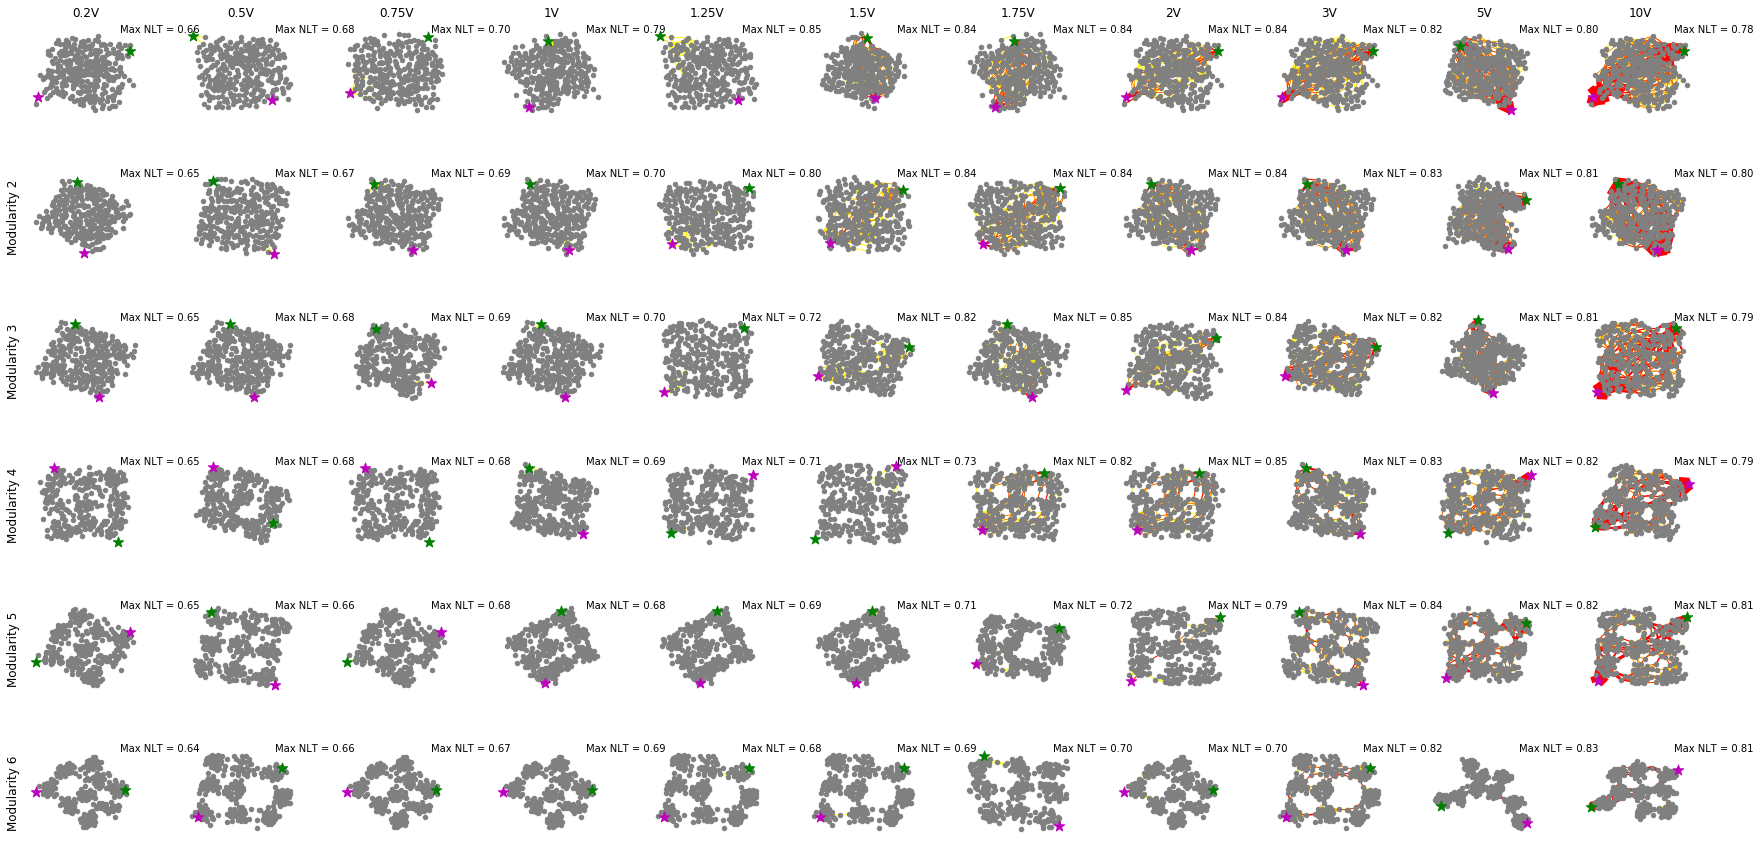

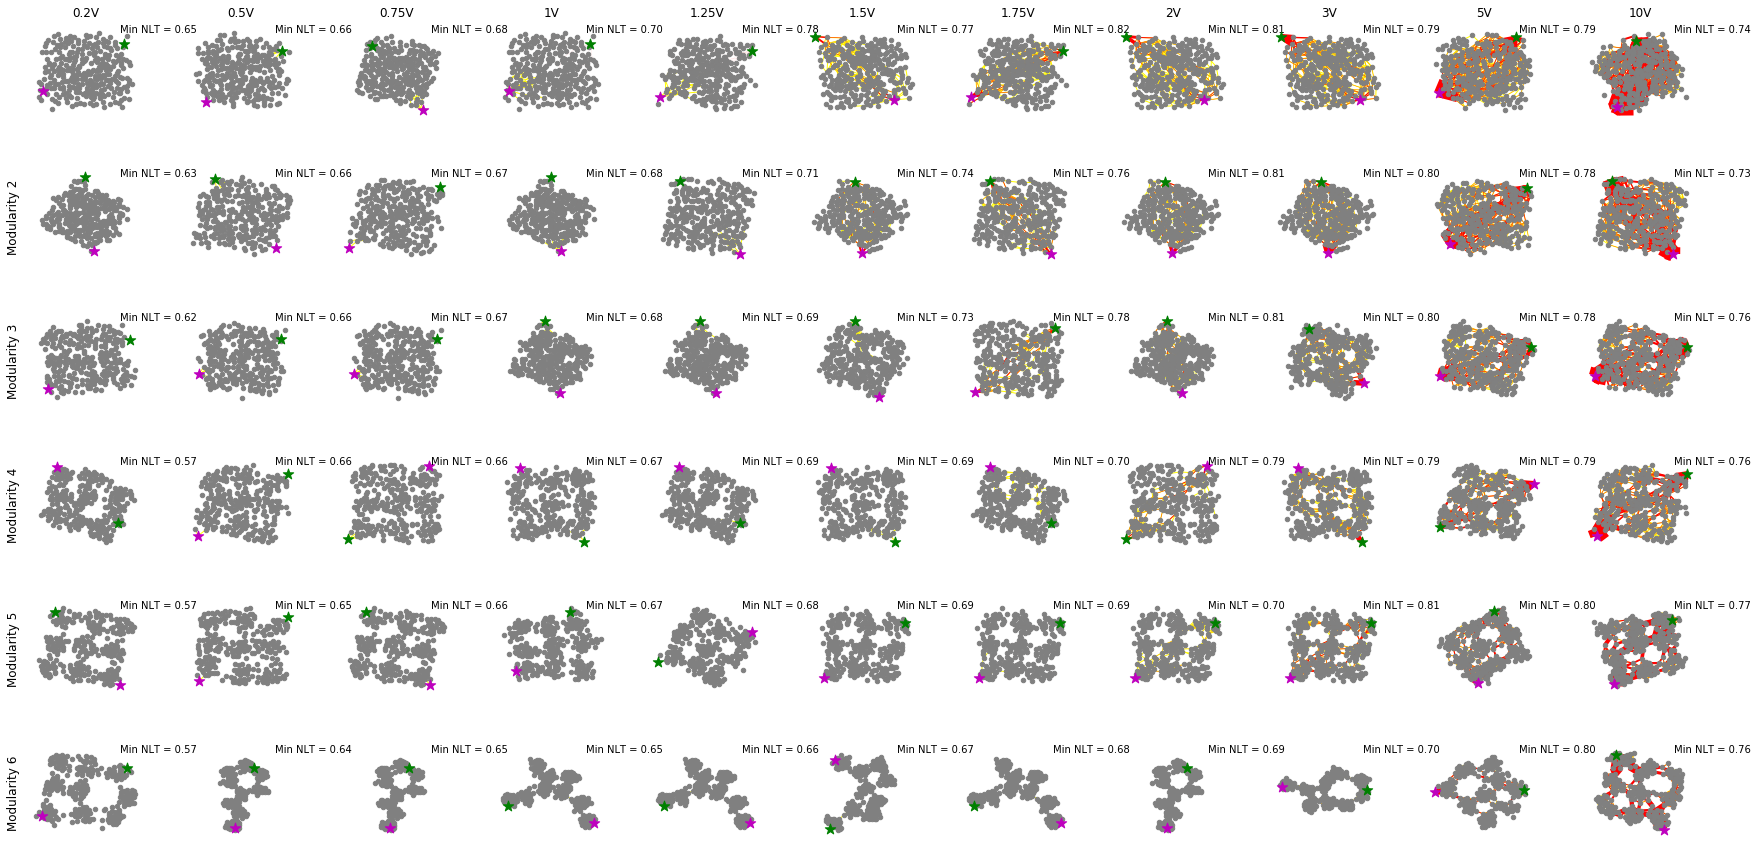

In [100]:
#### PLOT SUBGRAPHS + CURRENT OVERLAY
#Max NLT
fig,axes=plt.subplots(6,11,figsize=(30,15),sharex=True,sharey=True)
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.3)

for i in tqdm(range(len(subgraph_NLT_new))):
    #For each density
    for j in tqdm(range(len(subgraph_NLT_new[i]))):
        #find top + bottom network
        maxNW=np.argmax(newResults[i][j])
        ax=axes[j][i]
        G=current_new[i][j][maxNW]
        edges=G.edges()
        weights=[G[u][v]['weight'] for u,v in edges]
        weights=[i * 1e7 for i in np.abs(weights)]
        OGgraphMax=NWN[j][maxNW]['G']
        minNW=np.argmin(newResults[i][j])
        #draw OG graph
        pos=nx.kamada_kawai_layout(OGgraphMax)
        nx.draw_networkx_nodes(OGgraphMax,pos=pos,node_color='grey',node_size=20,ax=ax)
        #show Max subgraph
        if j == 0:
            ax.set_title(str(onAmp[i])+'V')
        if i == 0 and j > 0:
            ax.set_title('Modularity ' + str(distanceFromCenter[0][j]), rotation='vertical',x=-0.1,y=0.7)
        h=nx.draw_networkx_edges(subgraph_NLT_new[i][j][maxNW],pos=pos,node_size=20,edge_color='yellow',ax=ax)#np.max(np.hstack(DEG)))
        h2=nx.draw_networkx_edges(G,pos=pos,width=weights,ax=ax,edge_color='r')
        nx.draw_networkx_nodes(subgraph_NLT_new[i][j][maxNW],pos=pos,nodelist=[sources_new[i][j][maxNW]],node_color='g',node_size=120,node_shape ='*',ax=ax)
        nx.draw_networkx_nodes(subgraph_NLT_new[i][j][maxNW],pos=pos,nodelist=[drains_new[i][j][maxNW]],node_color='m',node_size=120,node_shape ='*',ax=ax)
        ax.set_frame_on(False)
        ax.text(0.7,1,'Max NLT = '+"{0:.2f}".format(maxNLT[i][j][0]))
#         set_trace()
        ax.set_yticks([])
        ax.set_xticks([])
        #show current overlay
plt.savefig(saveLoc+'VSweep 300NWN Varying Modularity - Current + Threshold Graphs MAX NLT.png',format='png',dpi=300)

#### Min NLT
fig,axes=plt.subplots(6,11,figsize=(30,15),sharex=True,sharey=True)
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.3)
#For each voltage,
for i in tqdm(range(len(subgraph_NLT_new))):
    #For each density
    for j in tqdm(range(len(subgraph_NLT_new[i]))):
        #find top + bottom network
        minNW=np.argmin(newResults[i][j])
        ax=axes[j][i]
        G=current_new[i][j][minNW]
        edges=G.edges()
        weights=[G[u][v]['weight'] for u,v in edges]
        weights=[i * 1e7 for i in np.abs(weights)]
        OGgraphMin=NWN[j][minNW]['G']
        #draw OG graph
        pos=nx.kamada_kawai_layout(OGgraphMin)
        nx.draw_networkx_nodes(OGgraphMin,pos=pos,node_color='grey',node_size=20,ax=ax)
        if j == 0:
            ax.set_title(str(onAmp[i])+'V')
        if i == 0 and j > 0:
            ax.set_title('Modularity ' + str(distanceFromCenter[0][j]), rotation='vertical',x=-0.1,y=0.7)
        #show Max subgraph
        h=nx.draw_networkx_edges(subgraph_NLT_new[i][j][minNW],pos=pos,node_size=20,edge_color='yellow',ax=ax)#np.max(np.hstack(DEG)))
        h2=nx.draw_networkx_edges(G,pos=pos,width=weights,ax=ax,edge_color='r')
        nx.draw_networkx_nodes(subgraph_NLT_new[i][j][minNW],pos=pos,nodelist=[sources_new[i][j][minNW]],node_color='g',node_size=120,node_shape ='*',ax=ax)
        nx.draw_networkx_nodes(subgraph_NLT_new[i][j][minNW],pos=pos,nodelist=[drains_new[i][j][minNW]],node_color='m',node_size=120,node_shape ='*',ax=ax)
        ax.set_frame_on(False)
        ax.text(0.7,1,'Min NLT = '+"{0:.2f}".format(minNLT[i][j][0]))
        #show current overlay
        ax.set_yticks([])
        ax.set_xticks([])
plt.savefig(saveLoc+'VSweep 300NWN Varying Modularity - Current + Threshold Graphs MIN NLT.png',format='png',dpi=300)



#add small worldness for each nw

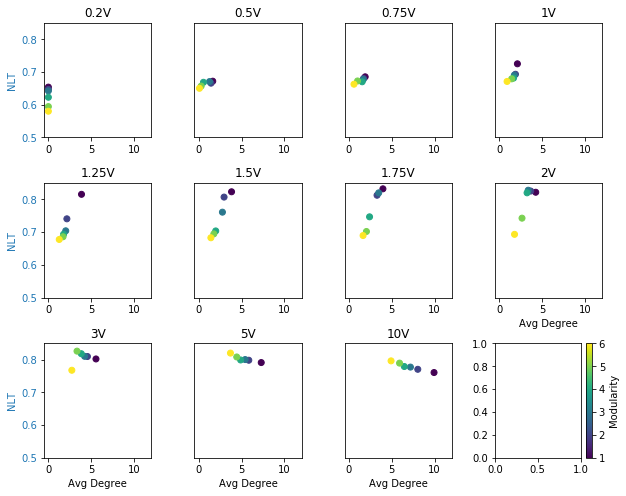

In [147]:
#Voltage vs Avg Degree vs Accuracy:

fig,axes=plt.subplots(3,4,figsize=(10,8))
fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)
i=0
xx=[]
for ax in axes.flat:#for each voltage:
    #plot accuracy vs density:
    if i < 11:
        ax.set_title(str(onAmp[i])+'V')
        ax.set_xlim([-0.5,12])
        ax.set_ylim(0.5,0.85)
        if i == 0 or i == 4 or i == 8:
            ax.set_ylabel('NLT',color='tab:blue')
            ax.tick_params(axis='y',labelcolor='tab:blue')
        else:
            ax.set_yticks([])
        y=np.mean(newResults[i],axis=1)
        err=np.std(newResults[i],axis=1)/np.sqrt(len(newResults[i]))
        x=np.mean(subgrphAvgDegree[i],axis=1)
        a=ax.scatter(x,y,c=distanceFromCenter[i])

#         ax.fill_between(np.mean(subgrphAvgDegree[i],axis=1),y-err,y+err,alpha=0.3)
        if i==7 or i == 8 or i ==9 or i ==10:
            ax.set_xlabel('Avg Degree')
#         ax2=ax.twinx()
#         ax2.set_ylim(0,12.5)
#         if i == 3 or i == 7 or i == 10:
#             ax2.set_ylabel('MC',color='r')
#             ax2.tick_params(axis='y',labelcolor='red')

#         else:
#             ax2.set_yticks([])
#         y2=np.mean(newResultsMC[i],axis=denseAxis)
#         err2=np.std(newResultsMC[i],axis=denseAxis)/np.sqrt(len(newResultsMC[i]))
#         ax2.plot(x,y2,'r')
#         ax2.fill_between(x,y2-err2,y2+err2,color='r',alpha=0.3)
        
        #max accuracy standardized NLT + MC
#         yy=np.mean(asn_acc_new[i],axis=denseAxis)
#         yy2=np.mean(asn_mc_new[i],axis=denseAxis)
#         xx.append(x[np.argmax(yy2+yy)])
#         ax2.vlines(xx[i],linestyles='dashed',ymin=0,ymax=12.5)

    else:
        plt.colorbar(a,ax=ax,label='Modularity')
    i=i+1
    
plt.savefig(saveLoc+'Subgraph AvgDeg vs NLT - VSweep 300NWN Varying Modularity.png',format='png',dpi=300)

### Functional Subgraph Analysis

##### Current, Current Path + Conductance

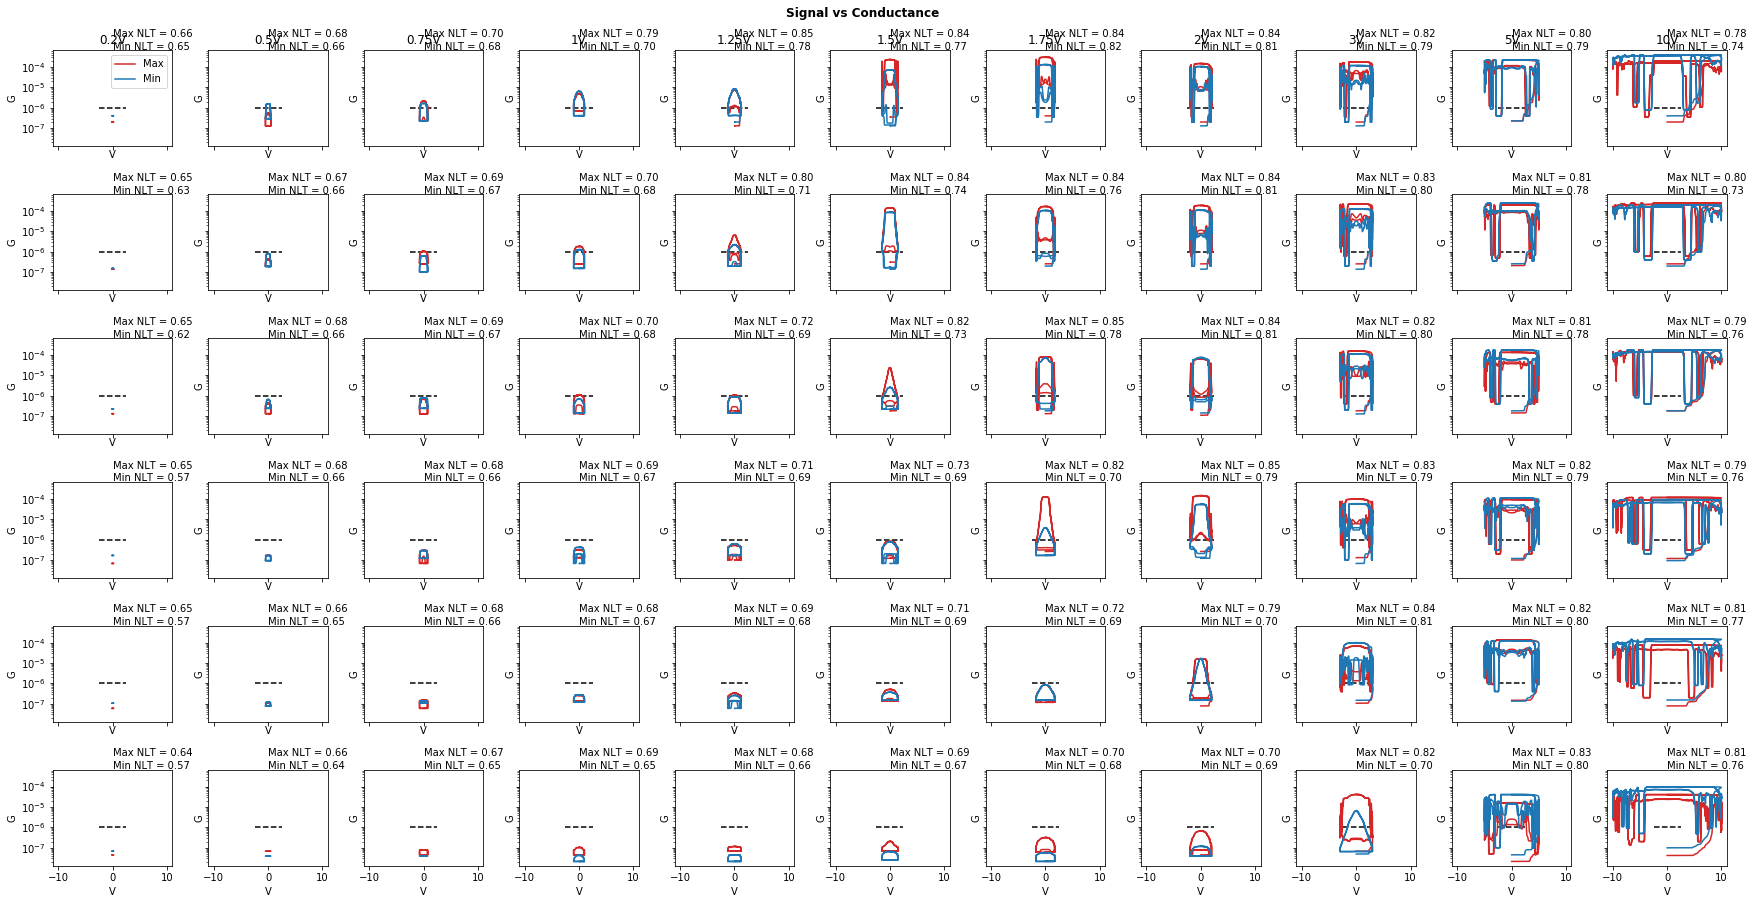

In [105]:
#Plot Conductance of Max NWS
fig,axes=plt.subplots(6,11,figsize=(30,15),sharex=True,sharey=True)
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.3)

fig.suptitle('Signal vs Conductance',y=0.92,weight='bold')

for i in range(len(NWN_NLT_sims_new)):
    for j in tqdm(range(len(NWN_NLT_sims_new[i]))):
        
        maxNW=np.argmax(newResults[i][j])
        ax=axes[j][i]
        if j == 0:
            ax.set_title(str(onAmp[i])+'V')
        x=NWN_NLT_sims_new[i][j][maxNW]['Signal'][0].signal
        a=ax.semilogy(x,NWN_NLT_sims_new[i][j][maxNW]['conductance'],c='tab:red')
        ax.set_ylabel('G')
        ax.set_xlabel('V')
        minNW=np.argmin(newResults[i][j])
        x1=NWN_NLT_sims_new[i][j][minNW]['Signal'][0].signal
        b=ax.semilogy(x1,NWN_NLT_sims_new[i][j][minNW]['conductance'],c='tab:blue')
        ax.text(0,7e-4,'Min NLT = '+"{0:.2f}".format(minNLT[i][j][0]))
        ax.text(0,3e-3,'Max NLT = '+"{0:.2f}".format(maxNLT[i][j][0]))
        ax.set_ylabel('G')
        ax.set_xlabel('V')
        ax.hlines(1e-6,xmin=-2.5,xmax=2.5,linestyles='dashed')
        if j == 0 and i == 0:
            ax.legend([a[0],b[0]],['Max','Min'])
plt.savefig(saveLoc+'VSweep 300NWN Varying Modularity - V vs G - MaxMin NLT.pdf',format='pdf',dpi=300)
  

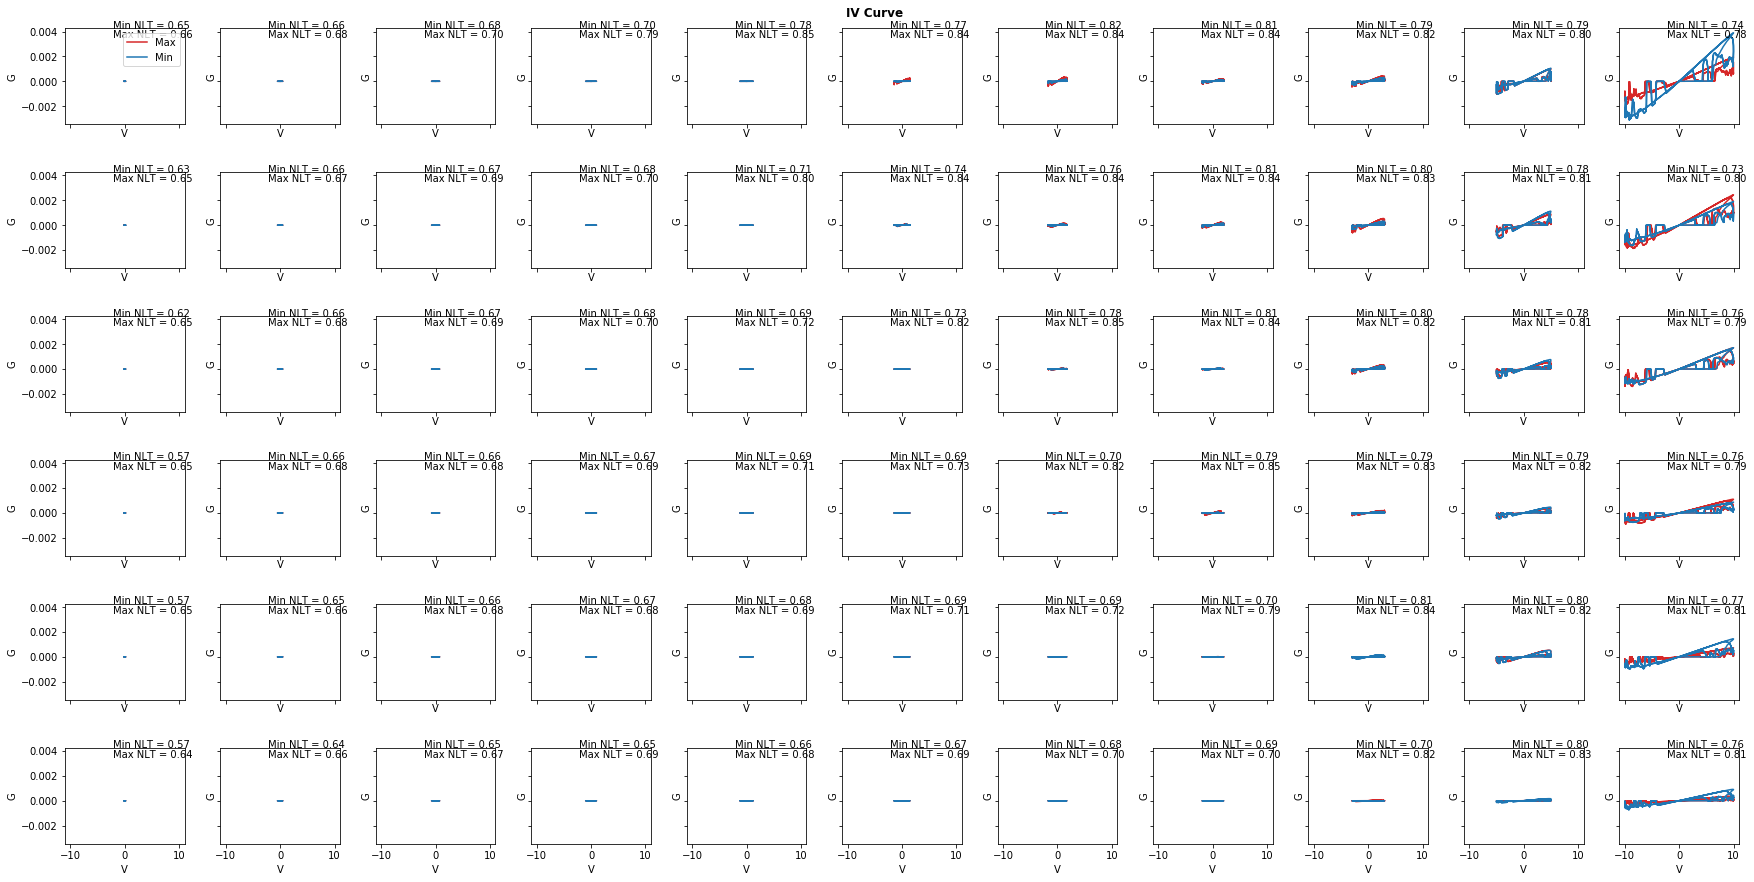

In [160]:
#Plot IV Curves MaxMin
fig,axes=plt.subplots(6,11,figsize=(30,15),sharex=True,sharey=True)
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.3)
fig.suptitle('IV Curve',y=0.9,weight='bold')

for i in tqdm(range(len(NWN_NLT_sims_new))):
    for j in range(len(NWN_NLT_sims_new[i])):
        maxNW=np.argmax(newResults[i][j])
        ax=axes[j][i]
        x=NWN_NLT_sims_new[i][j][maxNW]['Signal'][0].signal
        a=ax.plot(x,x/(1/NWN_NLT_sims_new[i][j][maxNW]['conductance']),c='tab:red')
        ax.set_ylabel('G')
        ax.set_xlabel('V')
        minNW=np.argmin(newResults[i][j])
        x1=NWN_NLT_sims_new[i][j][minNW]['Signal'][0].signal
        b=ax.plot(x1,x1/(1/NWN_NLT_sims_new[i][j][minNW]['conductance']),c='tab:blue')
#         ax.hlines(1e-6,xmin=-2.5,xmax=2.5,linestyles='dashed')
        ax.annotate('Min NLT = '+"{0:.2f}".format(minNLT[i][j][0]),xy=(0.4,1),xycoords='axes fraction')
        ax.annotate('Max NLT = '+"{0:.2f}".format(maxNLT[i][j][0]),xy=(0.4,0.9),xycoords='axes fraction')
        ax.set_ylabel('G')
        ax.set_xlabel('V')
        if j == 0 and i == 0:
            ax.legend([a[0],b[0]],['Max','Min'])
plt.savefig(saveLoc+'VSweep 300NWN Varying Modularity - Current vs Voltage MaxMin - NLT.png',format='png',dpi=300)    

In [ ]:
#Plot Number of Switches ON
fig,axes=plt.subplots(6,3,figsize=(10,20),sharex=True,sharey=True)
fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.3)
fig.suptitle('Num Switches On at T=5sec',y=0.92,weight='bold')

for i in range(len(NWN_NLT_sims_new)):
    for j in tqdm(range(len(NWN_NLT_sims_new[i]))):
        for k in range(len(NWN_NLT_sims_new[i][j])):
            maxNW=np.argmax(newResults[volts[i]][j][k])
            ax=axes[j][i]
            x=np.sum(NWN_NLT_sims_new[i][j][k]['Switch'])
            a=ax.scatter(newResults[volts[i]][j][k],x,c='black')
            ax.set_xlabel('NLT')
            ax.set_ylabel('# ON Switches')

In [280]:
temp=np.array(NWN_NLT_sims).reshape(11,10,6)
NWN_NLT_sims=[]
for i in range(len(temp)):
    NWN_NLT_sims.append(temp[i].T)
degreeDist=np.array(degreeDist).reshape(6,10)

In [281]:
temp=np.array(networksFlipped).reshape(10,6)
newNetworks=temp.T


In [282]:
### CURRENT VS NODE DEGREE
maxCurr=[[] for i in range(len(newResults))]
edgeLists=[[] for i in range(len(newResults))]
degree=[[] for i in range(len(newResults))]
for i in tqdm(range(len(current_new))):
    for j in range(len(current_new[i])):
        idx=idxMaxNLT[i][j][0]
        idxMin=idxMinNLT[i][j][0]
        edge_list=newNetworks[j][idx]['edge_list']
        nwCurrent = np.zeros(nx.from_numpy_array(newNetworks[j][idx]['adj_matrix']).number_of_nodes())
        for E in range(len(edge_list)):
            jnV=NWN_NLT_sims[i][j][idx]['JunctionVoltage']
            if jnV[E] > 0:
                nwCurrent[edge_list[E,0]] = nwCurrent[edge_list[E,0]] + jnV[E]
            else:
                nwCurrent[edge_list[E,1]] = nwCurrent[edge_list[E,1]] + jnV[E]
        degree[i].append(degreeDist[j][idx])        
        maxCurr[i].append(np.abs(nwCurrent))
        #only positive current:

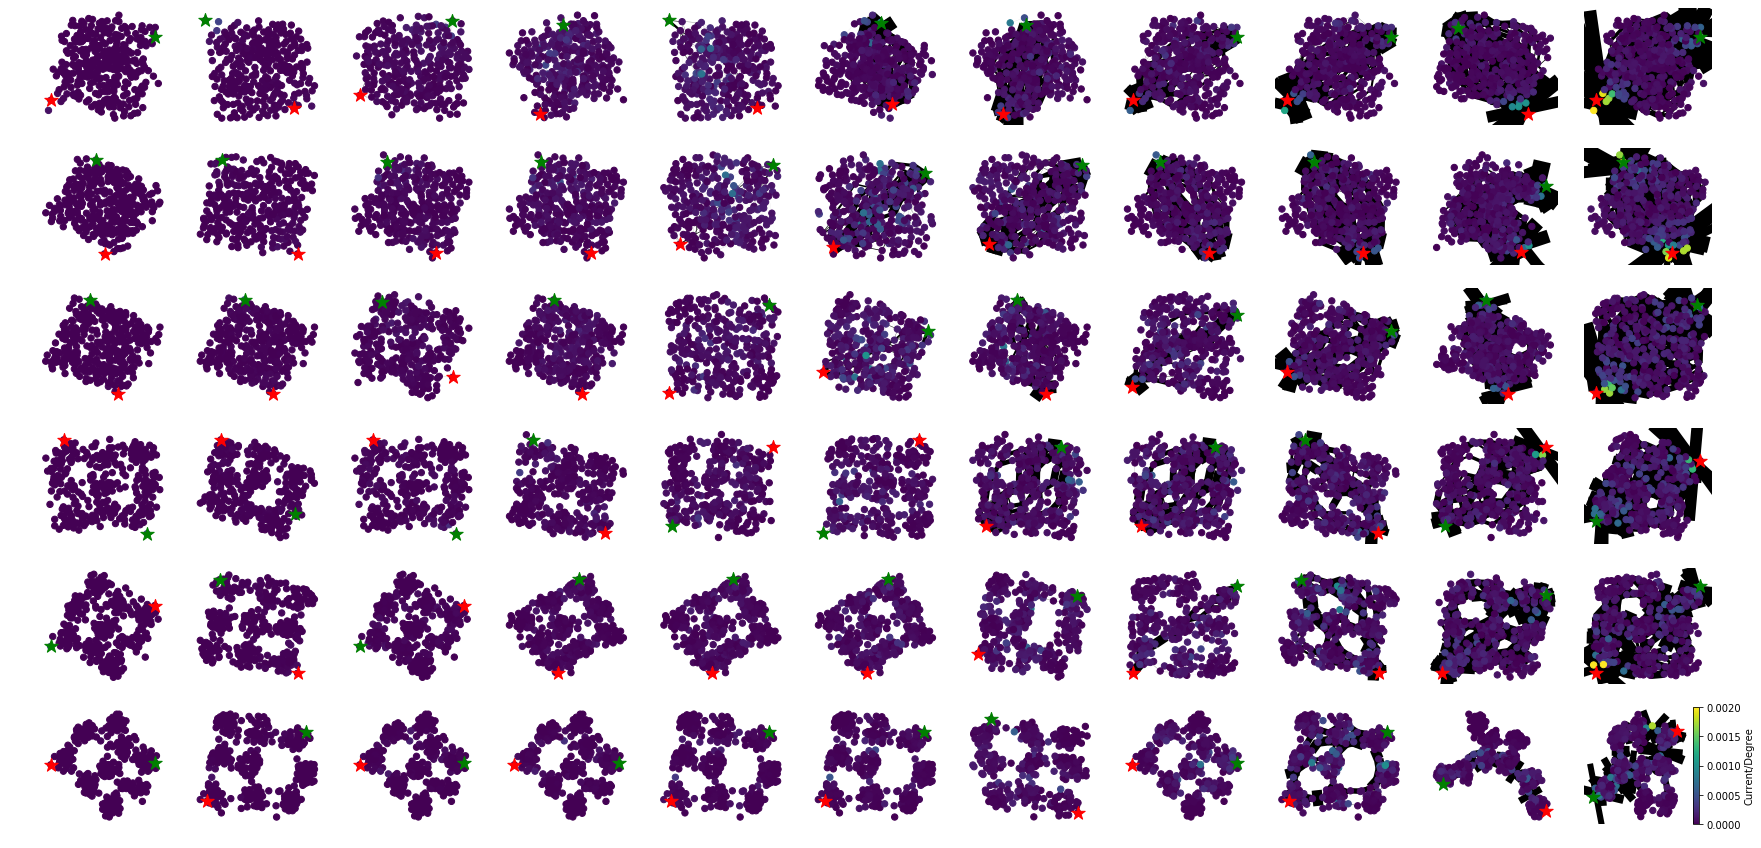

In [308]:
#CURRENT divided by DEGREE
fig,axes=plt.subplots(6,11,figsize=(30,15))
for i in range(len(newResults)):
    for j in tqdm(range(len(newResults[i]))):
        ax=axes[j][i]
        idx=idxMaxNLT[i][j][0]
        G=current_new[i][j][idx]
        OGgraphMax=nx.from_numpy_array(newNetworks[j][idx]['adj_matrix'])
        pos=nx.kamada_kawai_layout(OGgraphMax)
        edges=G.edges()
        weights=[G[u][v]['weight'] for u,v in edges]
        weights=[i * 1e8 for i in (weights)]
        cmap=plt.cm.viridis
        color=maxCurr[i][j]/degree[i][j]
        vmin = 0
        vmax = 0.002
        pos=nx.kamada_kawai_layout(OGgraphMax)
        a=nx.draw(G,node_size=40,pos=pos,node_color=color,width=weights,cmap=cmap,vmin=vmin, vmax=vmax,ax=ax)
        nx.draw_networkx_nodes(G,node_size=200,pos=pos,nodelist=[sources_new[i][j][idx]],node_color='g',node_shape='*',ax=ax)
        nx.draw_networkx_nodes(G,node_size=200,pos=pos,nodelist=[drains_new[i][j][idx]],node_color='r',node_shape='*',ax=ax)
    
    if i == 10:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
        sm._A = []
        plt.colorbar(sm,ax=ax,label='Current/Degree')

In [284]:
#Current Path formation analysis
vSet=0.01
currentPathFormation=[];numCurrentPaths=[];allCurrentPathsFormation=[];currPathLen=[]
maxCond=[];minCond=[]
for i in range(len(NWN_NLT_sims_new)):
    for j in range(len(NWN_NLT_sims_new[i])):
        for k in range(len(NWN_NLT_sims_new[i][j])):
            if NWN_NLT_sims_new[i][j][k]['CurrentPath'][1]:
                currentPathFormation.append(NWN_NLT_sims_new[i][j][k]['CurrentPath'][1][0])
                numCurrentPaths.append(len(NWN_NLT_sims_new[i][j][k]['CurrentPath'][1]))
#                 for m in range(len(NWN_NLT_sims[i][j][k]['CurrentPath'][0])): #for each current path:
                currPathLen.append(len(NWN_NLT_sims_new[i][j][k]['CurrentPath'][0][0]))
            else:
                currPathLen.append(0)
                currentPathFormation.append(-0.1)
                numCurrentPaths.append(0)
            maxCond.append(np.max(NWN_NLT_sims_new[i][j][k]['conductance']))
            minCond.append(np.min(NWN_NLT_sims_new[i][j][k]['conductance']))

In [285]:
maxCond=np.array(maxCond).reshape(11,6,10)
minCond=np.array(minCond).reshape(11,6,10)

currentPathFormation=np.array(currentPathFormation).reshape(11,6,10)
numCurrentPaths=np.array(numCurrentPaths).reshape(11,6,10)

In [286]:
idxNoCurrentPath=currentPathFormation<0
idxCurrentPath=currentPathFormation>0

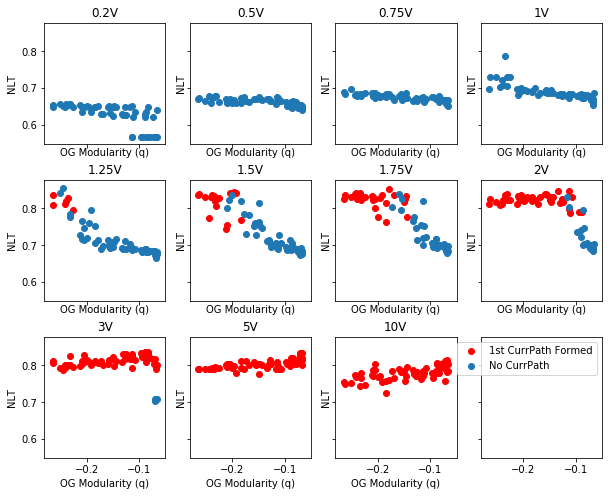

In [314]:
plt.rcParams['pdf.fonttype'] = 42
#Avg Deg vs Current Path formation 

fig,axes=plt.subplots(3,4,figsize=(10,8),sharex=True,sharey=True)
fig.subplots_adjust(hspace=0.3)
volt=0
for ax in axes.flat:
    if volt<11:
        ax.set_title(str(onAmp[volt]) + 'V')
        a=ax.scatter(np.log10(np.array(mod)[idxCurrentPath[volt]]),newResults[volt][idxCurrentPath[volt]],c='r',label='CurrPath Formed')
        b=ax.scatter(np.log10(np.array(mod)[idxNoCurrentPath[volt]]),newResults[volt][idxNoCurrentPath[volt]],label='No CurrPath')
        ax.set_xlabel('OG Modularity (q)')
        ax.set_ylabel('NLT')
    volt=volt+1
    plt.legend([a,b],['1st CurrPath Formed','No CurrPath'])


plt.savefig(saveLoc+'Mod vs NLT Current Path Formation All Volts- VSweep 300NWN Varying Modularity.pdf',format='pdf',dpi=300)

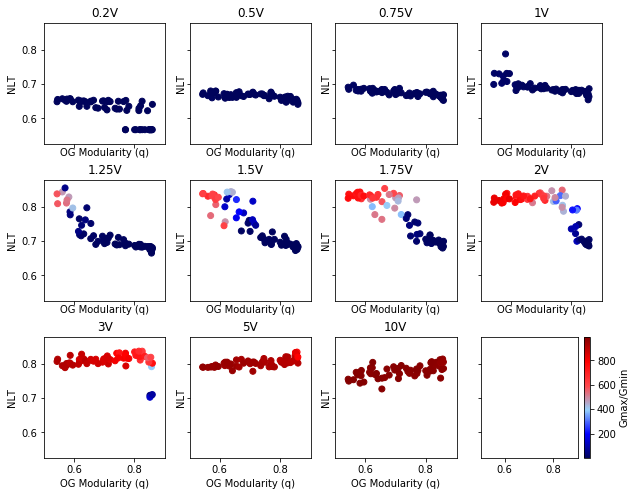

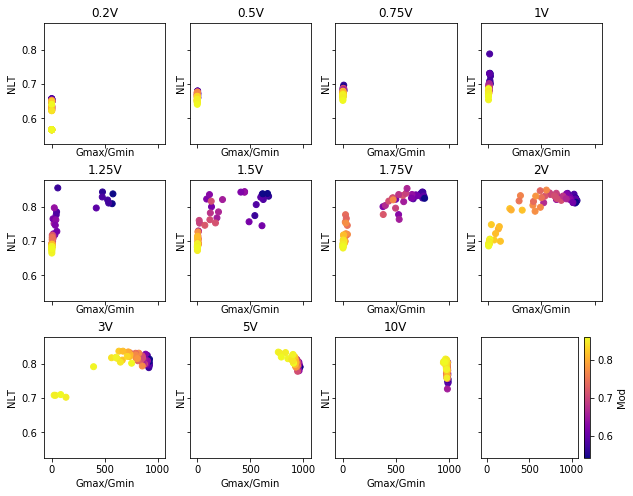

In [316]:
plt.rcParams['pdf.fonttype'] = 42

fig,axes=plt.subplots(3,4,figsize=(10,8),sharex=True,sharey=True)
fig.subplots_adjust(hspace=0.3)
cm1 = clrs.LinearSegmentedColormap.from_list("MyCmapName",["#00035b","b","#95d0fc","#ff474c","r","#840000"])

volt=0
for ax in axes.flat:
    if volt<11:
        ax.set_title(str(onAmp[volt]) + 'V')
        a=ax.scatter(np.array(mod),newResults[volt],c=maxCond[volt]/minCond[volt],cmap=cm1,vmin=np.min(maxCond/minCond),vmax=np.max(maxCond/minCond))
#         ax.set_xscale('symlog',basex=10)
        ax.set_xlabel('OG Modularity (q)')
        ax.set_ylabel('NLT')
    else:
        cb=plt.colorbar(a,ax=ax,label='Gmax/Gmin')
    volt=volt+1

# plt.savefig(saveLoc+'Avg Deg vs NLT Current Path Formation Conductance All Volts - VSweep 300NWN Varying Density.pdf',format='pdf',dpi=300)    
plt.rcParams['pdf.fonttype'] = 42
fig,axes=plt.subplots(3,4,figsize=(10,8),sharex=True,sharey=True)
fig.subplots_adjust(hspace=0.3)
volt=0
for ax in axes.flat:
    if volt<11:
        ax.set_title(str(onAmp[volt]) + 'V')
        b=ax.scatter(maxCond[volt]/minCond[volt],newResults[volt],c=mod,cmap=plt.cm.plasma,vmin=np.min(mod),vmax=np.max(mod))
#         ax.set_xscale('symlog',basex=10)
        ax.set_xlabel('Gmax/Gmin')
        ax.set_ylabel('NLT')
    else:
        cb=plt.colorbar(b,ax=ax,label='Mod')
    volt=volt+1

# plt.savefig(saveLoc+'MaxMin Conductance vs NLT and AvgDeg All Volts- VSweep 300NWN Varying Density.pdf',format='pdf',dpi=300)    

In [297]:
numCurrentPaths=np.array(numCurrentPaths).reshape(11,6,10)

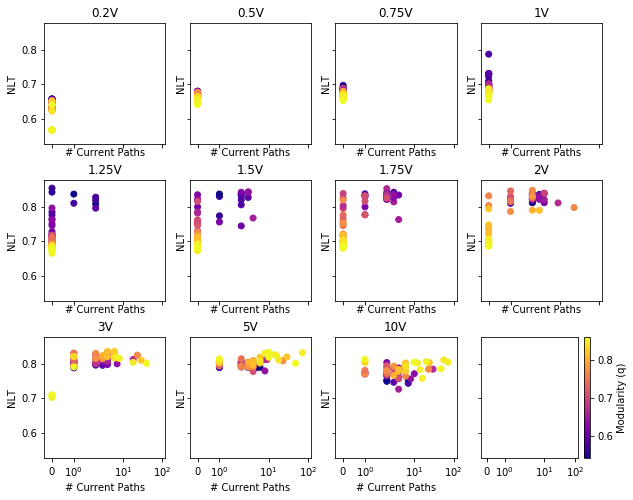

In [302]:
plt.rcParams['pdf.fonttype'] = 42
#Avg Deg vs Num Current Paths formed 
import matplotlib.colors as clrs

fig,axes=plt.subplots(3,4,figsize=(10,8),sharex=True,sharey=True)
fig.subplots_adjust(hspace=0.3)
volt=0
for ax in axes.flat:
    if volt<11:
        ax.set_title(str(onAmp[volt]) + 'V')
        a=ax.scatter(numCurrentPaths[volt],newResults[volt],cmap=plt.cm.plasma,c=mod)
        ax.set_xscale('symlog',basex=10)
        ax.set_ylabel('NLT')
        ax.set_xlabel('# Current Paths')
    else:
        plt.colorbar(a,ax=ax,label='Modularity (q)')
    volt=volt+1

plt.savefig(saveLoc+'Num Current Paths vs NLT and Modularity All Volts- VSweep 300NWN Varying Modularity.pdf',format='pdf',dpi=300)

In [304]:
cm1 = clrs.LinearSegmentedColormap.from_list("MyCmapName",["#00035b","b","#95d0fc","#ff474c","r","#840000"])


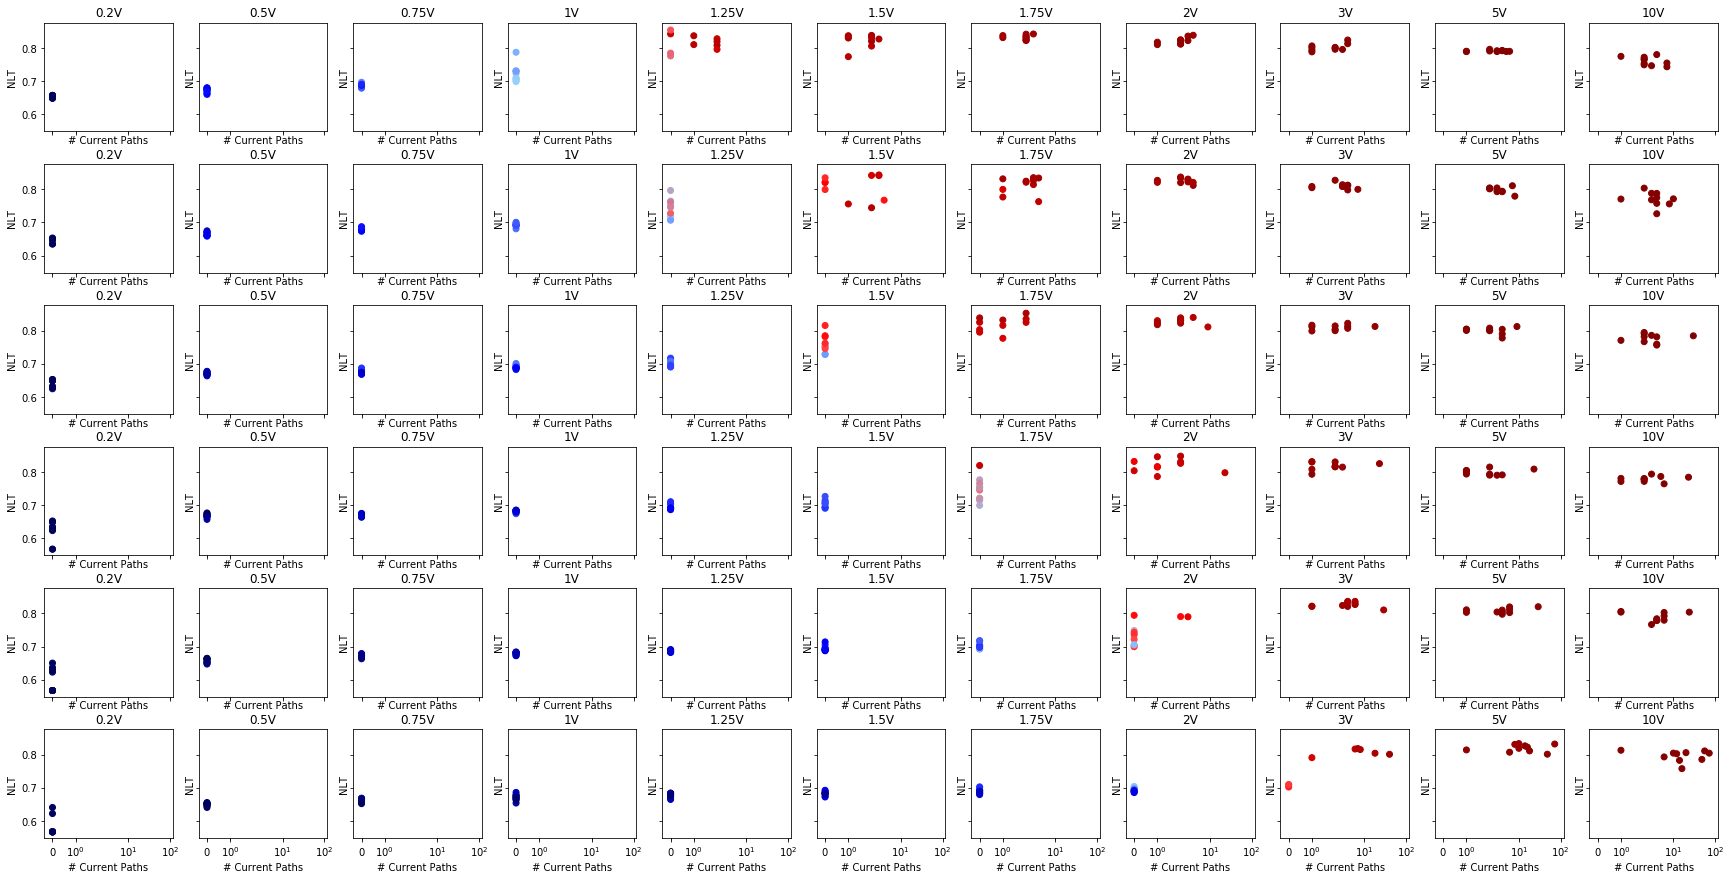

In [305]:
plt.rcParams['pdf.fonttype'] = 42
#Avg Deg vs Num Current Paths formed 
import matplotlib.colors as clrs

fig,axes=plt.subplots(6,11,figsize=(30,15),sharex=True,sharey=True)
fig.subplots_adjust(hspace=0.3)
for i in range(len(NWN_NLT_sims_new)):
    for j in tqdm(range(len(NWN_NLT_sims_new[i]))):
        ax=axes[j][i]
        ax.set_title(str(onAmp[i]) + 'V')
        a=ax.scatter(numCurrentPaths[i][j],newResults[i][j],c=maxCond[i][j]/minCond[i][j],cmap=cm1,norm=clrs.LogNorm(),vmin=np.min(maxCond/minCond),vmax=np.max(maxCond/minCond))
        ax.set_xscale('symlog',basex=10)
        ax.set_ylabel('NLT')
        ax.set_xlabel('# Current Paths')

plt.savefig(saveLoc+'Num Current Paths vs NLT and GmaxGmin All Volts All Densities- VSweep 300NWN Varying Modularity.pdf',format='pdf',dpi=300)

In [ ]:
currPathLen=np.array(currPathLen).reshape(11,20,10)

In [ ]:
#Current Path Time:
plt.rcParams['pdf.fonttype'] = 42
#Avg Deg vs Num Current Paths formed 

# # fig,axes=plt.subplots(3,4,figsize=(10,8),sharex=True,sharey=True)
# fig,axes=plt.subplots(20,11,figsize=(30,60),sharex=True,sharey=True)
# fig.subplots_adjust(hspace=0.3)
# # volt=0
# # for ax in axes.flat:
# #     if volt<11:
# for i in range(len(NWN_NLT_sims_new)):
#     for j in tqdm(range(len(NWN_NLT_sims_new[i]))):
#         ax=axes[j][i]
#         ax.set_title(str(onAmp[i]) + 'V')
#         a=ax.scatter(currentPathFormation[i][j],newResults[i][j],cmap=cm1,c=maxCond[i][j]/minCond[i][j],norm=clrs.LogNorm(),vmin=np.min(maxCond/minCond),vmax=np.max(maxCond/minCond))
#         ax.set_ylabel('NLT')
#         ax.set_xlabel('Current Path Formation Time')
#         ax.set_xlim([-0.2,1])
# #     else:
# #         plt.colorbar(a,ax=ax,label='AvgDeg')
# #     volt=volt+1
# plt.savefig(saveLoc+'Current Path Formation Times vs NLT and AvgDeg All Volts + Densities - VSweep 300NWN Varying Density.pdf',format='pdf',dpi=300)

# plt.rcParams['pdf.fonttype'] = 42
#Avg Deg vs Num Current Paths formed 

fig,axes=plt.subplots(3,4,figsize=(10,8),sharex=True,sharey=True)
fig.subplots_adjust(hspace=0.3)
volt=0
for ax in axes.flat:
    if volt<11:
        ax.set_title(str(onAmp[volt]) + 'V')
        a=ax.scatter(currPathLen[volt],newResults[volt],cmap=plt.cm.plasma,c=avgDeg,norm=clrs.LogNorm(),vmin=np.min(avgDeg),vmax=np.max(avgDeg))
        ax.set_xscale('symlog',basex=10)
        ax.set_ylabel('NLT')
        ax.set_xlabel('1st Current Path Length')
        ax.set_xlim([-0.4,1e2])
    else:
        plt.colorbar(a,ax=ax,label='AvgDeg')
    volt=volt+1

plt.savefig(saveLoc+'Length 1st Current Path vs NLT and AvgDeg All Volts- VSweep 300NWN Varying Density.pdf',format='pdf',dpi=300)


# plt.rcParams['pdf.fonttype'] = 42
# #Avg Deg vs Num Current Paths formed vs Time of current path
# import matplotlib.colors as clrs

# fig,axes=plt.subplots(3,4,figsize=(10,8),sharex=True,sharey=True)
# fig.subplots_adjust(hspace=0.3)
# volt=0
# for ax in axes.flat:
#     if volt<11:
#         ax.set_title(str(onAmp[volt]) + 'V')
#         a=ax.scatter(currentPathFormation[volt],numCurrentPaths[volt],cmap=plt.cm.plasma,c=avgDeg,norm=clrs.LogNorm())
#         ax.set_yscale('symlog',basex=10)
#         ax.set_xlabel('1st CurrPaths Time')
#         ax.set_ylabel('# CurrPaths')
#     else:
#         plt.colorbar(a,ax=ax,label='AvgDeg')
#     volt=volt+1

# plt.savefig(saveLoc+'Num Current Paths vs Current Path Time and AvgDeg All Volts- VSweep 300NWN Varying Density.pdf',format='pdf',dpi=300)

In [ ]:
# Node Level Graph Theory

In [35]:
#REMOVE ALL NAN'S AND ZERO-SIZED PCOEFF AND MZ SUBGRAPHS:
tmp=[[None]*len(subgrphPC_MC[2]) for i in range(len(subgrphPC_MC))]
tmp2=[[None]*len(subgrphPC[2]) for i in range(len(subgrphPC))]
subgrphPC_MC2=[];subgrphPC2=[]
for i in range(len(subgrphPC_MC)):
    count=0;count2=0
    for j in range(len(subgrphPC_MC[i])):
        if ~np.isnan(subgrphPC_MC[i][j]).all():
            if len(subgrphPC_MC[i][j])>1:
                tmp[i][j]=subgrphPC_MC[i][j]
            else:
                tmp[i][j]=None
        if ~np.isnan(subgrphPC[i][j]).all():
            if len(subgrphPC[i][j])>1:
                tmp2[i][j]=subgrphPC[i][j]
            else:
                tmp2[i][j]=None
    subgrphPC2.append(np.array(tmp2[i]).reshape(6,10))
    subgrphPC_MC2.append(np.array(tmp[i]).reshape(6,10))

tmp=[[None]*len(subgrphMZ_MC[2]) for i in range(len(subgrphMZ_MC))]
tmp2=[[None]*len(subgrphMZ[2]) for i in range(len(subgrphMZ))]
subgrphMZ_MC2=[];subgrphMZ2=[]
for i in range(len(subgrphMZ_MC)):
    count=0;count2=0
    for j in range(len(subgrphMZ_MC[i])):
        if ~np.isnan(subgrphMZ_MC[i][j]).all():
            if len(subgrphMZ_MC[i][j])>1:
                tmp[i][j]=subgrphMZ_MC[i][j]
            else:
                tmp[i][j]=None
        if ~np.isnan(subgrphMZ[i][j]).all():
            if len(subgrphMZ[i][j])>1:
                tmp2[i][j]=subgrphMZ[i][j]
            else:
                tmp2[i][j]=None
    subgrphMZ2.append(np.array(tmp2[i]).reshape(6,10))
    subgrphMZ_MC2.append(np.array(tmp[i]).reshape(6,10))

In [ ]:
#Subgraph PCOEFF for best and worst networks - NLT & MC
for volt in range(len(volts)):
    fig,axes=plt.subplots(2,3,figsize=(10,7),sharex=True,sharey=True)
    fig.subplots_adjust(hspace=.5)
    fig.subplots_adjust(wspace=.3)
    i=0
    fig.suptitle('Voltage = ' + str(onAmp[volts[volt]]) +'V, Task = NLT',y=0.93)

    for ax in tqdm(axes.flat): #for each density
        draw_zp_space(ax=ax)
        idx=idxMaxNLT[volt][i]
        ax.set_title('Modularity ' + str(distanceFromCenter[0][i]))
        pcMaxNLT=np.hstack([subgrphPC2[volt][i][j] for j in idx])
        mzMaxNLT=np.hstack([subgrphMZ2[volt][i][j] for j in idx])
        ax.text(0.3,8,'Max NLT = '+"{0:.2f}".format(np.max(maxNLT[volt][i])))
        ax.text(0.3,6,'Min NLT = '+"{0:.2f}".format(np.min(minNLT[volt][i])))
        ax.scatter(pcMaxNLT,mzMaxNLT,c='r')
        idx2=idxMinNLT[volt][i]
        pcMinNLT=np.hstack([subgrphPC2[volt][i][j] for j in idx2])
        mzMinNLT=np.hstack([subgrphMZ2[volt][i][j] for j in idx2])
        ax.scatter(pcMinNLT,mzMinNLT,c='b',alpha=0.5)
        i=i+1
    plt.savefig(saveLoc+'VSweep 300NWN Varying Modularity - Subgraph PC vs MZ Guimera - '+voltNames[volts[volt]]+'V NLT.png',format='png',dpi=300)

    #MC
    fig,axes=plt.subplots(2,3,figsize=(10,7))
    fig.subplots_adjust(hspace=.5)
    fig.subplots_adjust(wspace=.3)
    i=0
    fig.suptitle('Voltage = ' + str(onAmp[volts[volt]]) +'V, Task = MC',y=0.93)
    for ax in tqdm(axes.flat):
        draw_zp_space(ax=ax)
        idx=idxMaxMC[volt][i]
        ax.set_title('Modularity ' + str(distanceFromCenter[0][i]))
        pcMaxMC=np.hstack([subgrphPC_MC2[volt][i][j] for j in idx])
        mzMaxMC=np.hstack([subgrphMZ_MC2[volt][i][j] for j in idx])
        ax.text(0.3,8,'Max MC = '+"{0:.2f}".format(np.max(maxMC[volt][i])))
        ax.text(0.3,6,'Min MC = '+"{0:.2f}".format(np.min(minMC[volt][i])))
        ax.scatter(pcMaxMC,mzMaxMC,c='r')
        idx2=idxMinMC[volt][i]
        pcMinMC=np.hstack([subgrphPC_MC2[volt][i][j] for j in idx2])
        mzMinMC=np.hstack([subgrphMZ_MC2[volt][i][j] for j in idx2])
        ax.scatter(pcMinMC,mzMinMC,c='b',alpha=0.5)
        i=i+1
    plt.savefig(saveLoc+'VSweep 300NWN Varying Modularity - Subgraph PC vs MZ Guimera - '+voltNames[volts[volt]]+'V MC.png',format='png',dpi=300)


In [ ]:
idxMaxNLT[0][3]

In [ ]:
idx2

In [ ]:
idxMaxNLT

In [ ]:
for volt in range(len(volts)):
    fig,axes=plt.subplots(2,3,figsize=(10,7),sharex=True,sharey=True)
    fig.subplots_adjust(hspace=.3)
    fig.subplots_adjust(wspace=.3)
    i=0
    fig.suptitle('PCoeff Subgraph Histogram:\n Voltage = ' + str(onAmp[volts[volt]]) +'V, Task = NLT',y=1)
    for ax in axes.flat:
        ax.set_title('Modularity ' + str(distanceFromCenter[0][i]))
        idx=idxMaxNLT[volt][i]
        idx2=idxMinNLT[volt][i]

        pcMaxNLT=np.hstack([subgrphPC2[volt][i][j] for j in idx])
        mzMaxNLT=np.hstack([subgrphMZ2[volt][i][j] for j in idx])
        pcMinNLT=np.hstack([subgrphPC2[volt][i][j] for j in idx2])
        mzMinNLT=np.hstack([subgrphMZ2[volt][i][j] for j in idx2])
        if not pcMinNLT[0] is None:
            histMin, binsMin=np.histogram(pcMinNLT,10)
            widthMin=0.7 * (binsMin[1] - binsMin[0])
            centerMin=(binsMin[:-1] + binsMin[1:]) / 2
            ax.bar(centerMin, histMin, align='center', width=widthMin,label='Min',color='b')
            
        if not pcMaxNLT[0] is None:
            hist, bins=np.histogram(pcMaxNLT,10)
            width = 0.7 * (bins[1] - bins[0])
            center = (bins[:-1] + bins[1:]) / 2
            ax.bar(center, hist, align='center', width=width,label='Max',color='r',alpha=0.7)

        ax.set_xlim([0,1])
        if i >=3:
            ax.set_xlabel('PC')
        i=i+1
    plt.savefig(saveLoc+'VSweep 300NWN Varying Modularity - Subgraph PC Histograms - '+voltNames[volts[volt]]+'V NLT.png',format='png',dpi=300)


In [ ]:
for volt in range(len(volts)):
    fig,axes=plt.subplots(2,3,figsize=(10,7),sharex=True,sharey=True)
    fig.subplots_adjust(hspace=.3)
    fig.subplots_adjust(wspace=.3)
    i=0
    fig.suptitle('MZ Subgraph Histogram:\n Voltage = ' + str(onAmp[volts[volt]]) +'V, Task = NLT',y=1)
    for ax in axes.flat:
        ax.set_title('Modularity ' + str(distanceFromCenter[0][i]))
        idx=idxMaxNLT[volt][i]
        idx2=idxMinNLT[volt][i]

        pcMaxNLT=np.hstack([subgrphPC2[volt][i][j] for j in idx])
        mzMaxNLT=np.hstack([subgrphMZ2[volt][i][j] for j in idx])
        pcMinNLT=np.hstack([subgrphPC2[volt][i][j] for j in idx2])
        mzMinNLT=np.hstack([subgrphMZ2[volt][i][j] for j in idx2])
        if not mzMinNLT[0] is None:
            histMin, binsMin=np.histogram(mzMinNLT,10)
            widthMin=0.7 * (binsMin[1] - binsMin[0])
            centerMin=(binsMin[:-1] + binsMin[1:]) / 2
            ax.bar(centerMin, histMin, align='center', width=widthMin,label='Min',color='b')
            
        if not mzMaxNLT[0] is None:
            hist, bins=np.histogram(mzMaxNLT,10)
            width = 0.7 * (bins[1] - bins[0])
            center = (bins[:-1] + bins[1:]) / 2
            ax.bar(center, hist, align='center', width=width,label='Max',color='r',alpha=0.7)

#         ax.set_xlim([0,1])
        if i >=3:
            ax.set_xlabel('MZ')
        i=i+1
    plt.savefig(saveLoc+'VSweep 300NWN Varying Modularity - Subgraph MZ Histograms - '+voltNames[volts[volt]]+'V NLT.png',format='png',dpi=300)


### Case Studies

In [36]:
#Network Comparison Methods:
import netlsd as nd

maxmin_subgraph=[];specDist_subgraph=[];netsimile_subgraph=[];netlsd_subgraph=[];portDiv_subgraph=[];
for i in range(len(subgraph_NLT_new)):
    temp=[];tempMaxMin=[];temp2=[];temp3=[]
    for j in tqdm(range(len(subgraph_NLT_new[i]))):
        idx=idxMaxNLT[i][j][0]
        idxMin=idxMinNLT[i][j][0]
        gMax=subgraph_NLT_new[i][j][idx]
        gMin=subgraph_NLT_new[i][j][idxMin]
        A=nx.adjacency_matrix(gMax)
        B=nx.adjacency_matrix(gMin)
        desc1=nd.heat(gMax) # compute the signature)
        desc2=nd.heat(gMin)
        netlsd_subgraph.append(nd.compare(desc1, desc2))
        if len(subgraph_NLT_new[i][j][idx]) > 3 and len(subgraph_NLT_new[i][j][idxMin]) > 3:
            temp.append(portrait_divergence(gMax,gMin))
        else:
            temp.append(0)
        tempMaxMin.append(maxNLT[i][j][0]-minNLT[i][j][0])
        specDist_subgraph.append(np.linalg.norm(gammaMax[i][0][j]-gammaMin[volt][0][j]))
#     delcon.append(temp)
    maxmin_subgraph.append(tempMaxMin)
    portDiv_subgraph.append(temp)
#     specDist.append(temp3)
#     netsimile.append(temp2)
portDiv_subgraph=np.array(portDiv_subgraph).reshape(11,20)
specDist_subgraph=np.array(specDist_subgraph).reshape(11,20)
netlsd_subgraph=np.array(netlsd_subgraph).reshape(11,20)

NameError: name 'gammaMax' is not defined